# **Install and import libraries**

In [231]:
!pip install idx2numpy
import idx2numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

# Import Dataset and changing format type to numpy array
Instructions: Change the path variables(train_images_path,test_images_path,..) to the location of the dataset

In [0]:
train_images_path = 'train-images.idx3-ubyte'
test_images_path = 't10k-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'
test_labels_path = 't10k-labels.idx1-ubyte'
train_images = idx2numpy.convert_from_file(train_images_path)
test_images = idx2numpy.convert_from_file(test_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

# Creating Validation Set


In [0]:
train_X = train_images
test_X = test_images

train_X, val_X, train_labels, val_labels = train_test_split(train_X, train_labels, test_size=0.2, random_state=42)

# Converting numpy array to torch tensors and creating dataloader

In [0]:
X_train = torch.from_numpy(train_X).type(torch.DoubleTensor) 
X_val = torch.from_numpy(val_X).type(torch.DoubleTensor) 
X_test = torch.from_numpy(test_X).type(torch.DoubleTensor) 

Y_train = torch.from_numpy(train_labels).type(torch.LongTensor) 
Y_val = torch.from_numpy(val_labels).type(torch.LongTensor) 
Y_test = torch.from_numpy(test_labels).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train,Y_train)
val = torch.utils.data.TensorDataset(X_val,Y_val)
test = torch.utils.data.TensorDataset(X_test,Y_test)


train_loader = torch.utils.data.DataLoader(train, batch_size = 120, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 120, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 100, shuffle = True)

# 1. MNIST Classification using CNN :

**Defining layers and forward propagtion**

In [0]:

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3,3), stride = 1, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride = 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = (3,3), stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride = 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1((x))
        x = F.relu(self.conv2(x))
        x = self.maxpool2((x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
       

**Defining loss and Optimizer**

In [0]:
model = Model()
use_cuda  = True
if use_cuda and torch.cuda.is_available():
   model.cuda()
model = model.double()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

**Defining function to predict accuracy for large dataset**

In [0]:
def predict(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.view(-1,1,28,28)
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total
         

**Training**

In [263]:
epochs = 8
val_error = []
train_error = []
iter_val_error = 0
iter_train_error = 0
i= 0
for epoch in range(epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        i = i+1
        data = data.view(-1,1,28,28)
        
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        cost = loss(output,target)
        
        cost.backward()
        optimizer.step()
       
        if (i%50==0):
          val_acc = predict(val_loader)
          train_acc = predict(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

        
    


Train Epoch: 0 [5880/48000](12%)]	train_acc: 0.913917	val_acc: 0.912917
Train Epoch: 0 [11880/48000](25%)]	train_acc: 0.950396	val_acc: 0.950083
Train Epoch: 0 [17880/48000](37%)]	train_acc: 0.963375	val_acc: 0.960250
Train Epoch: 0 [23880/48000](50%)]	train_acc: 0.970562	val_acc: 0.966667
Train Epoch: 0 [29880/48000](62%)]	train_acc: 0.973063	val_acc: 0.965750
Train Epoch: 0 [35880/48000](75%)]	train_acc: 0.974000	val_acc: 0.969667
Train Epoch: 0 [41880/48000](87%)]	train_acc: 0.974417	val_acc: 0.969583
Train Epoch: 0 [47880/48000](100%)]	train_acc: 0.980021	val_acc: 0.973750
Train Epoch: 1 [5880/48000](12%)]	train_acc: 0.983396	val_acc: 0.977167
Train Epoch: 1 [11880/48000](25%)]	train_acc: 0.982500	val_acc: 0.976583
Train Epoch: 1 [17880/48000](37%)]	train_acc: 0.984375	val_acc: 0.976750
Train Epoch: 1 [23880/48000](50%)]	train_acc: 0.984750	val_acc: 0.976417
Train Epoch: 1 [29880/48000](62%)]	train_acc: 0.980458	val_acc: 0.973333
Train Epoch: 1 [35880/48000](75%)]	train_acc: 0.9858

**Plot Training and Validation error**

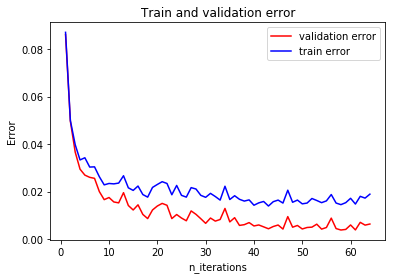

In [265]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

**Test accuracy over 10000 images**

In [266]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1,1,28,28)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * correct / total))

Test Accuracy on the 10000 test images: 98.300000 %


**Saving the model**


Instructions: provide path where model is to be saved

In [0]:
path = '/content/model'
torch.save(model.state_dict(),path)

**Predicting on random test images**

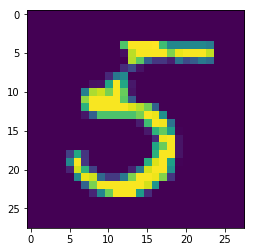

predicted label: 5
true label: 5


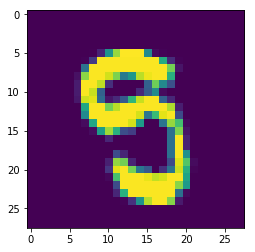

predicted label: 5
true label: 5


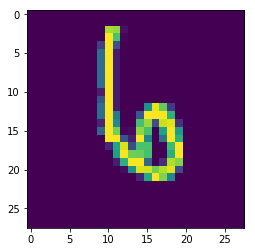

predicted label: 6
true label: 6


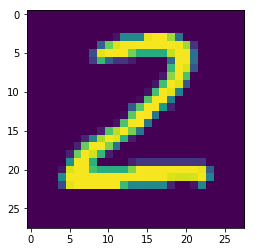

predicted label: 2
true label: 2


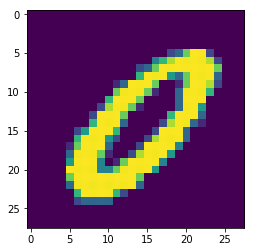

predicted label: 0
true label: 0


In [268]:
for i in range(5):
  image, label = next(iter(test_loader))  
  image = image[0]
  plt.imshow(image)
  plt.show()
  label = label[0]
  image = image.view(-1,1,28,28)
  image = image.cuda()
  label = label.cuda()
  output = model(image)
  predicted_label = torch.argmax(output)
  print('predicted label:',predicted_label.item())
  print('true label:',label.item())

**Batch Normalization**

In [0]:

class Model_BatchNorm(nn.Module):
    def __init__(self):
        super(Model_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3,3), stride = 1, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride = 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = (3,3), stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride = 2)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1((x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2((x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.fc2(x)
        return x
       

In [0]:
model2 = Model_BatchNorm()
use_cuda  = True
if use_cuda and torch.cuda.is_available():
   model2.cuda()
model2 = model2.double()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(),lr=0.001)

In [0]:
def predict2(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.view(-1,1,28,28)
            images = images.cuda()
            labels = labels.cuda()
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total
         

**Training**

In [250]:
epochs = 8
val_error = []
train_error = []
iter_val_error = 0
iter_train_error = 0
i= 0
for epoch in range(epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        i = i+1
        data = data.view(-1,1,28,28)
        
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          target = target.cuda()
        optimizer.zero_grad()
        output = model2(data)
        cost = loss(output,target)
        
        cost.backward()
        optimizer.step()
       
        if (i%50==0):
          val_acc = predict2(val_loader)
          train_acc = predict2(train_loader)
          print('Train Epoch: {} [{}/{}]({:.0f}%)]\ttrain_acc: {:.6f}\tval_acc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                train_acc,val_acc))
          val_error.append(1-train_acc)
          train_error.append(1-val_acc)

        
    


        
    


Train Epoch: 0 [5880/48000](12%)]	train_acc: 0.968021	val_acc: 0.968250
Train Epoch: 0 [11880/48000](25%)]	train_acc: 0.978688	val_acc: 0.976583
Train Epoch: 0 [17880/48000](37%)]	train_acc: 0.982771	val_acc: 0.980833
Train Epoch: 0 [23880/48000](50%)]	train_acc: 0.985042	val_acc: 0.982583
Train Epoch: 0 [29880/48000](62%)]	train_acc: 0.987604	val_acc: 0.984583
Train Epoch: 0 [35880/48000](75%)]	train_acc: 0.988083	val_acc: 0.983333
Train Epoch: 0 [41880/48000](87%)]	train_acc: 0.988167	val_acc: 0.985333
Train Epoch: 0 [47880/48000](100%)]	train_acc: 0.989833	val_acc: 0.985833
Train Epoch: 1 [5880/48000](12%)]	train_acc: 0.989313	val_acc: 0.985833
Train Epoch: 1 [11880/48000](25%)]	train_acc: 0.992188	val_acc: 0.987000
Train Epoch: 1 [17880/48000](37%)]	train_acc: 0.991854	val_acc: 0.986667
Train Epoch: 1 [23880/48000](50%)]	train_acc: 0.992687	val_acc: 0.987083
Train Epoch: 1 [29880/48000](62%)]	train_acc: 0.993062	val_acc: 0.987083
Train Epoch: 1 [35880/48000](75%)]	train_acc: 0.9921

**Plot Training and Validation Error**

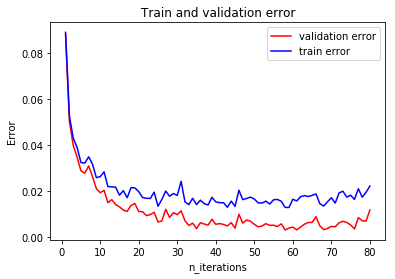

In [257]:
epoch = [i for i in range(1,len(val_error)+1)]
plt.plot(epoch,val_error,'-r')
plt.plot(epoch,train_error,'-b')
plt.title('Train and validation error')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('validation error','train error'))
plt.show()

**Test accuracy on 10000 test images**

In [258]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1,1,28,28)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy on the 10000 test images: %f %%' % (
    100 * correct / total))

Test Accuracy on the 10000 test images: 98.760000 %


# 2. Visualizing Convolutional Neural Network

**Visualizing conv1 32 filters**

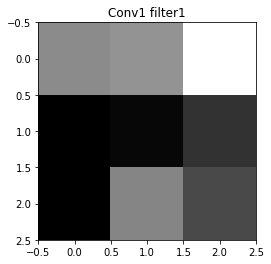

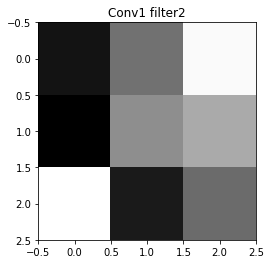

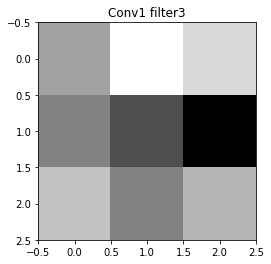

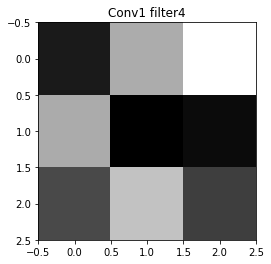

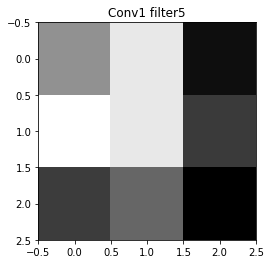

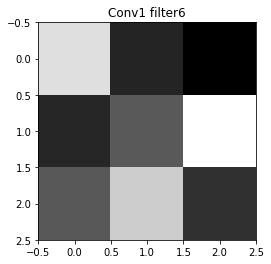

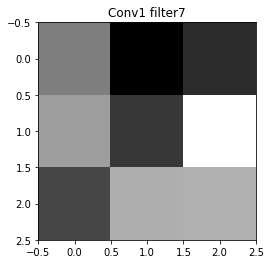

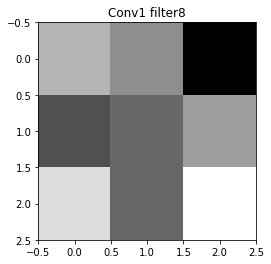

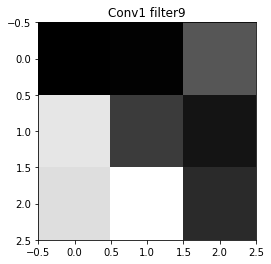

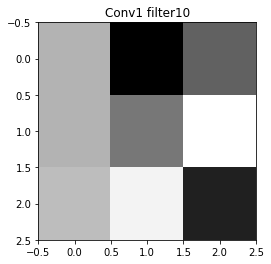

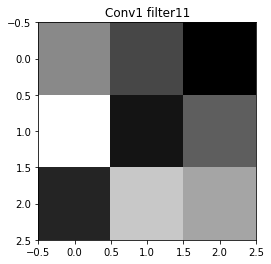

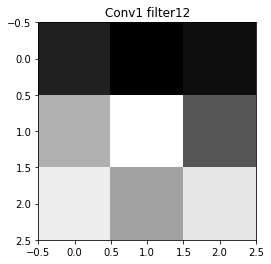

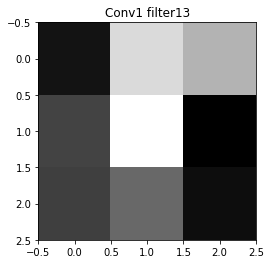

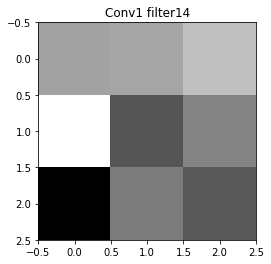

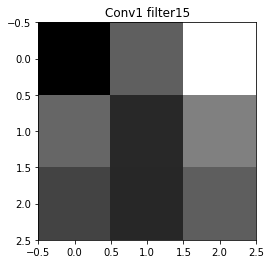

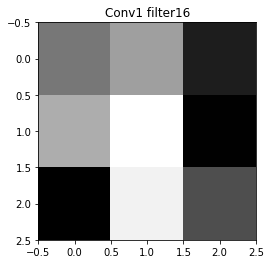

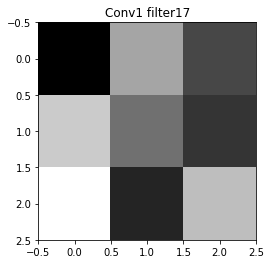

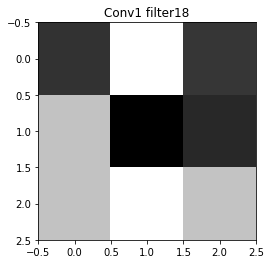

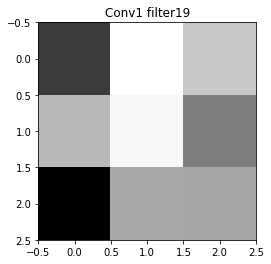

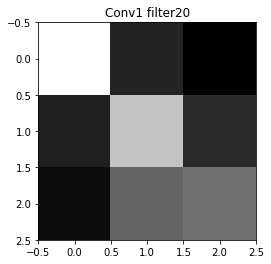

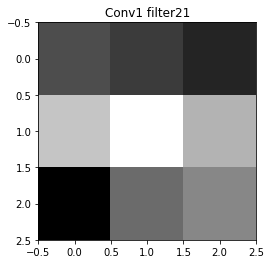

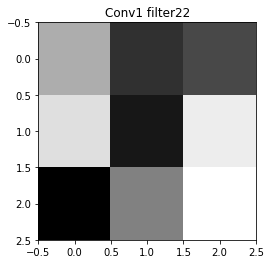

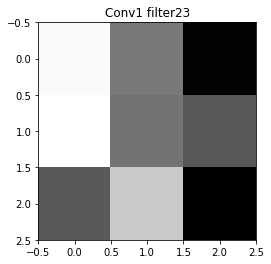

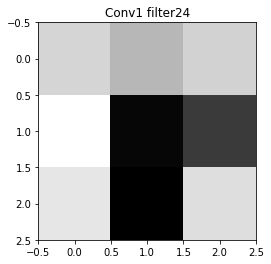

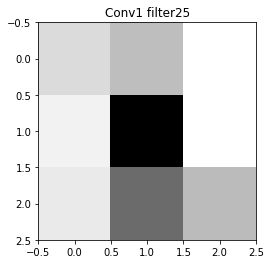

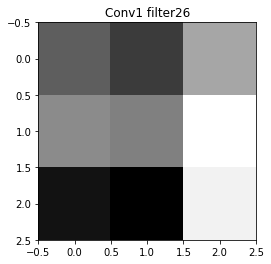

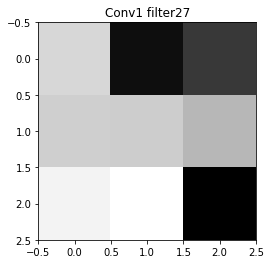

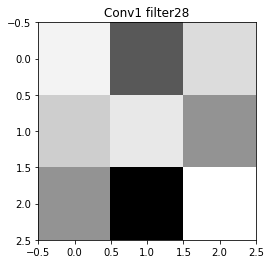

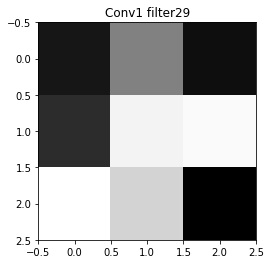

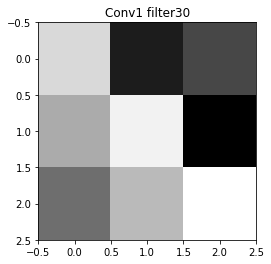

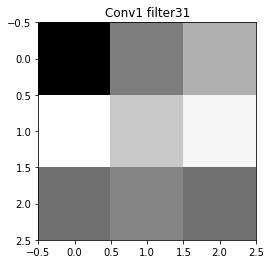

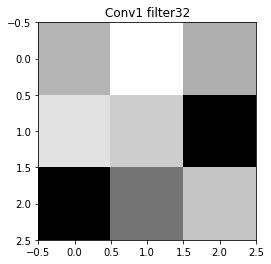

In [269]:

weight = model.cpu().conv1.weight.data.numpy()
for i in range(1,33):
    plt.imshow(weight[i-1,0,:,:],'gray')
    plt.title('Conv1 filter'+str(i))
    plt.show()

**Visualizing conv2 (1024) filters**

Plots of randomly selected 32 filters

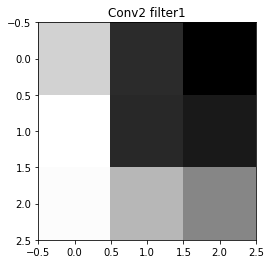

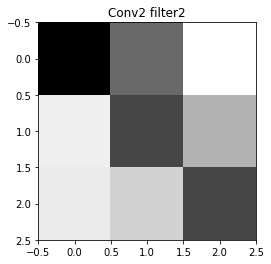

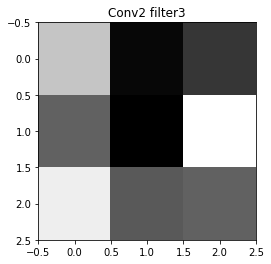

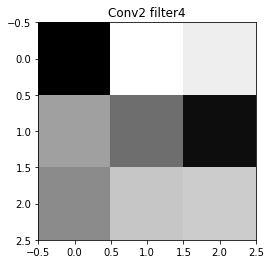

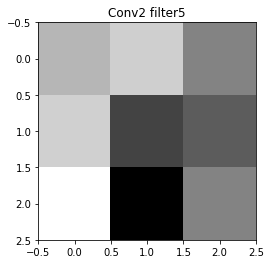

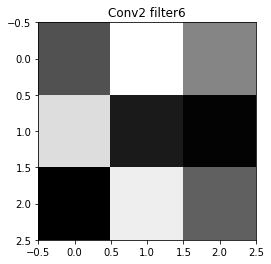

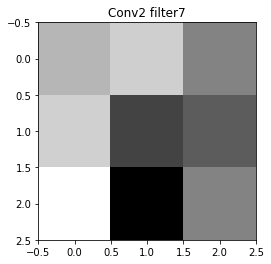

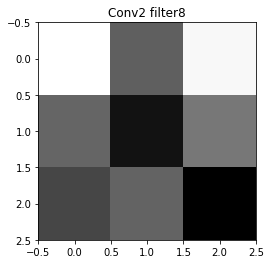

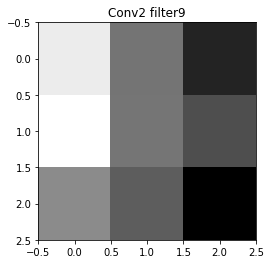

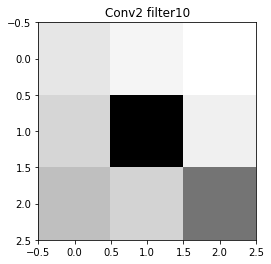

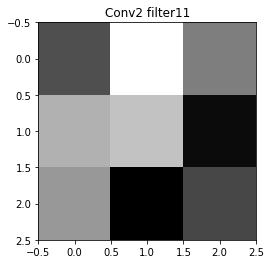

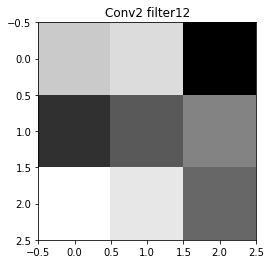

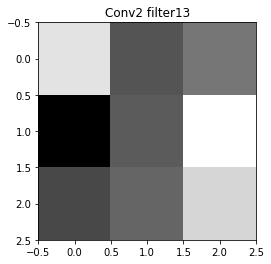

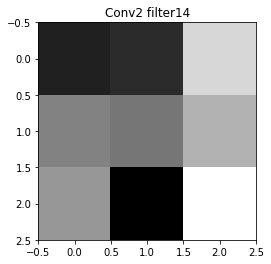

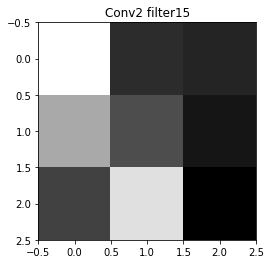

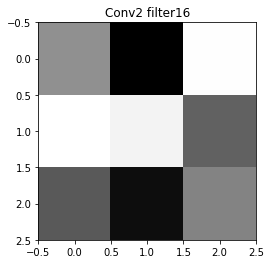

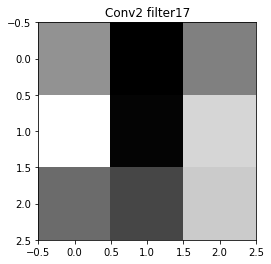

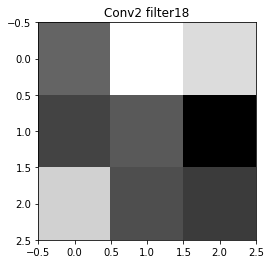

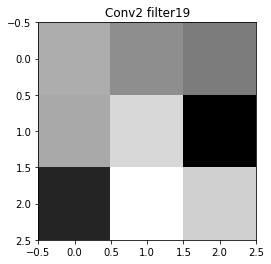

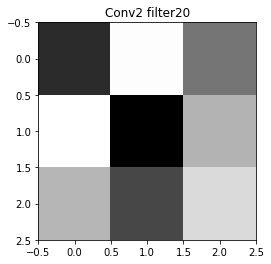

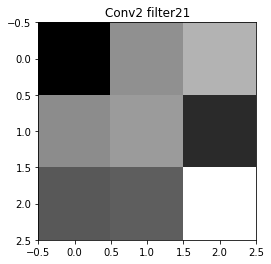

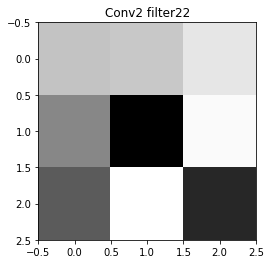

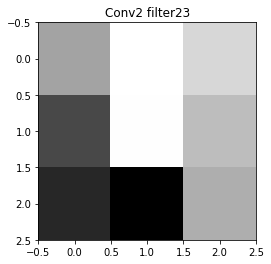

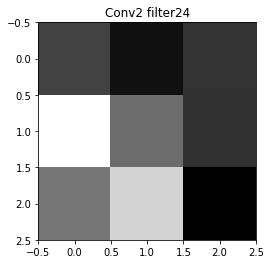

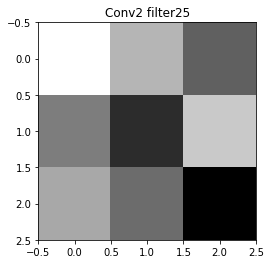

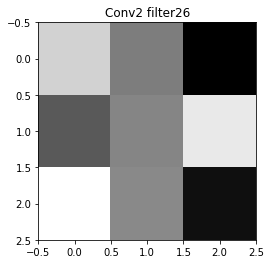

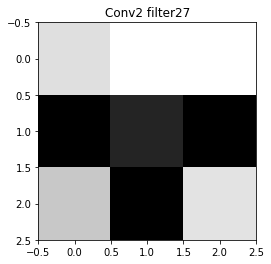

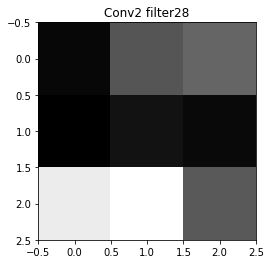

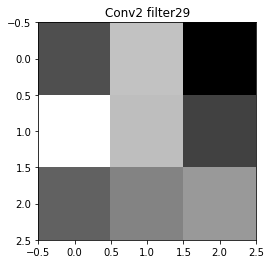

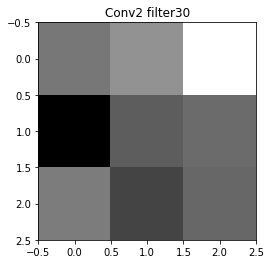

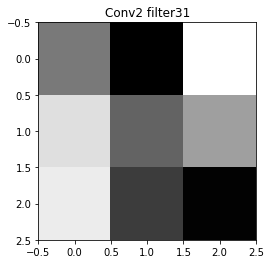

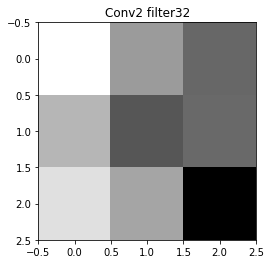

In [270]:
weight = model.cpu().conv2.weight.data.numpy()
for i in range(0,32):
    plt.imshow(weight[np.random.randint(0,32),np.random.randint(0,32),:,:],'gray')
    plt.title('Conv2 filter'+str(i+1))
    plt.show()

**Visualizing conv1 feature maps**

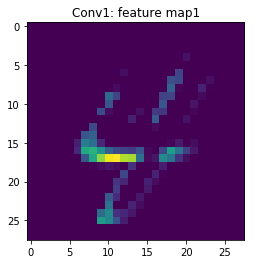

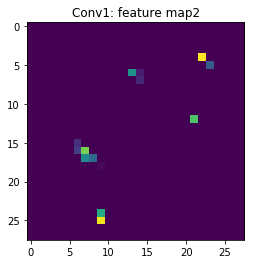

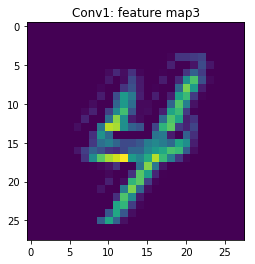

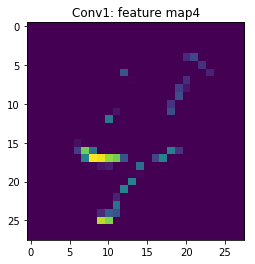

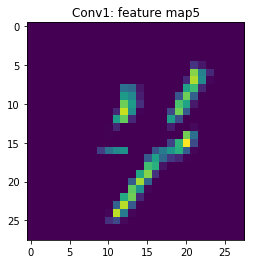

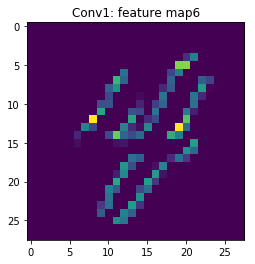

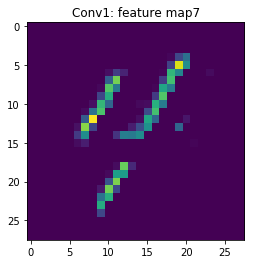

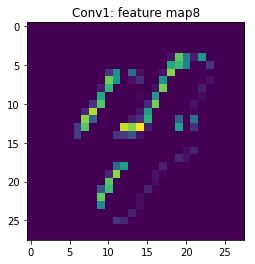

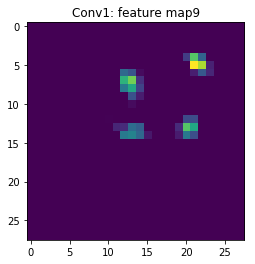

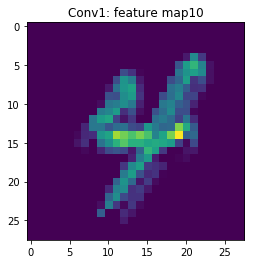

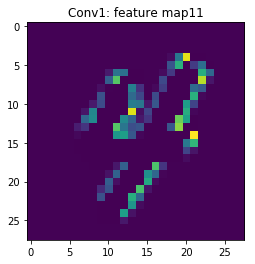

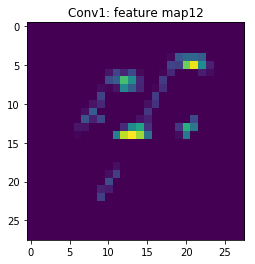

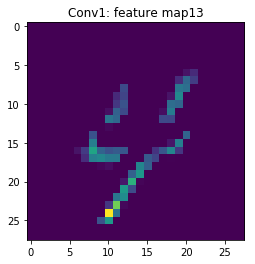

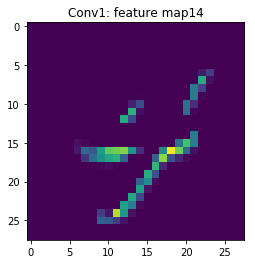

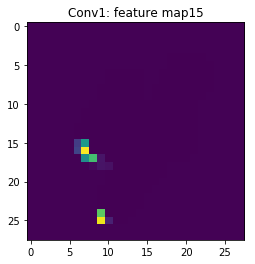

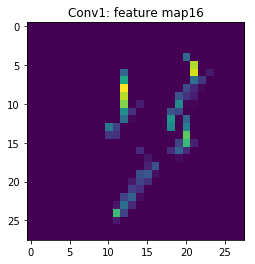

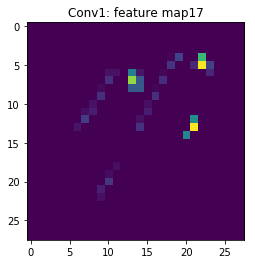

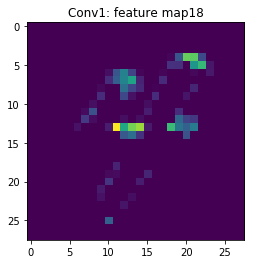

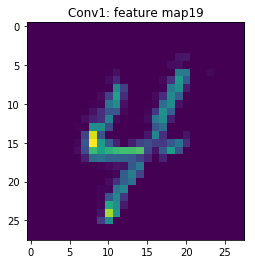

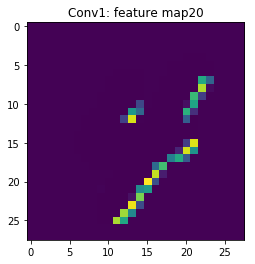

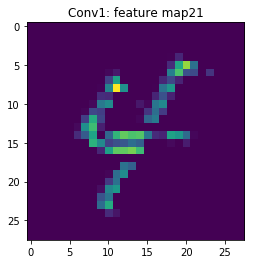

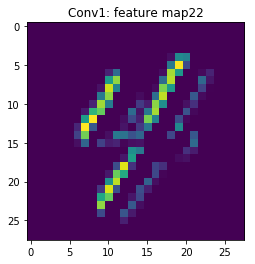

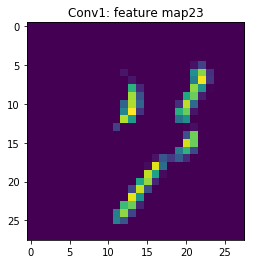

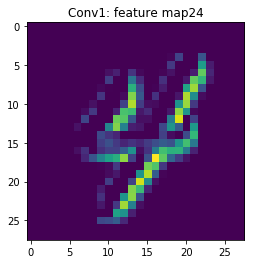

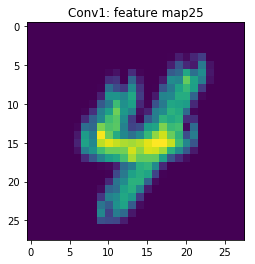

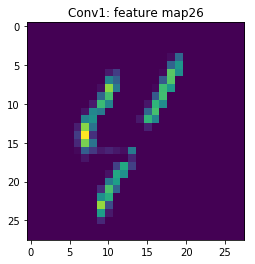

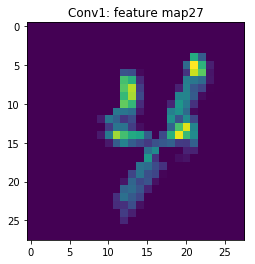

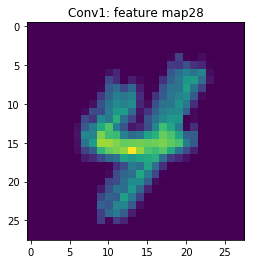

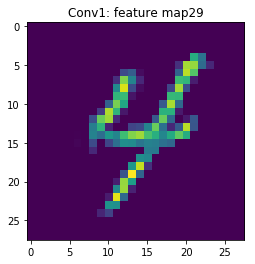

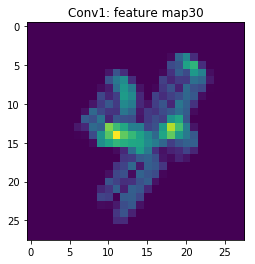

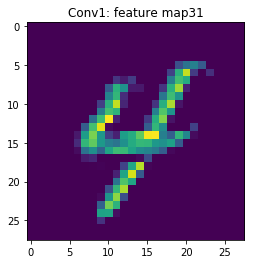

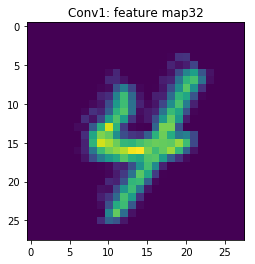

In [271]:
image, label = next(iter(test_loader))  
image = image[0]
image = image.view(-1,1,28,28)
image = image.cuda()
a = (F.relu(model.conv1(image.cpu()))).cpu().data.numpy()
for i in range(1,33):
    plt.imshow(a[0,i-1,:,:])
    plt.title('Conv1: feature map'+str(i))
    plt.show()

**conv1 feature maps together**

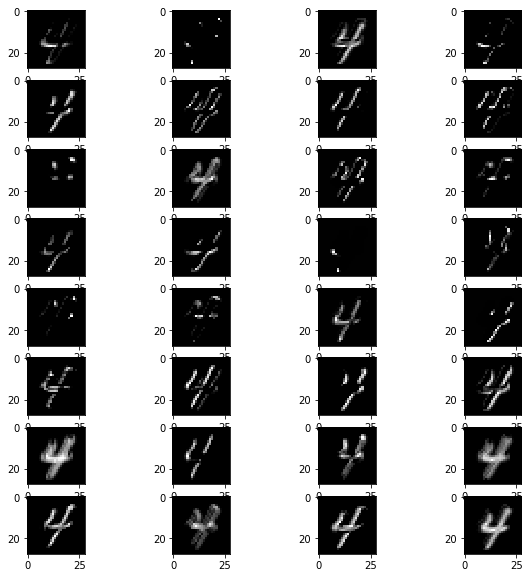

In [272]:
w=20
h=20
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 8
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(a[0,i-1,:,:],'gray')
plt.show()

**Visualizing feature maps of conv2**

(1, 32, 14, 14)


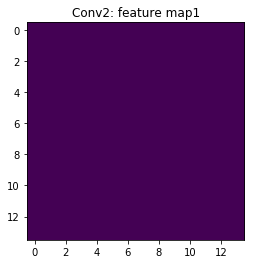

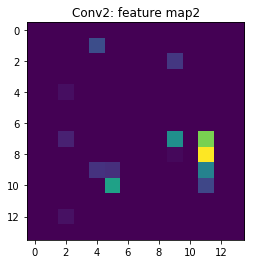

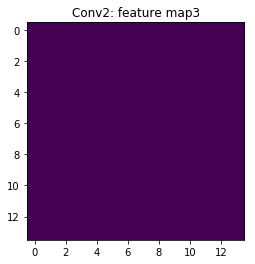

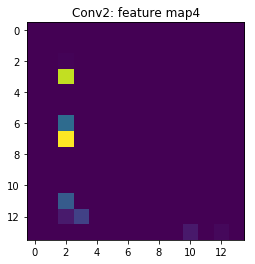

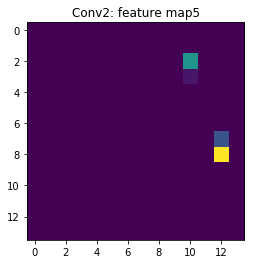

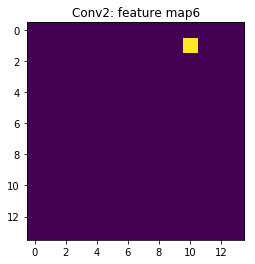

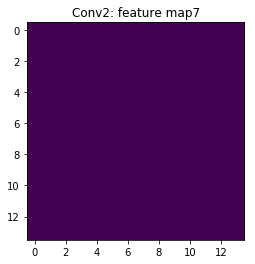

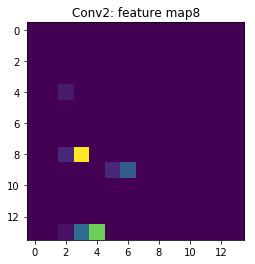

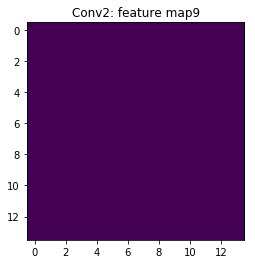

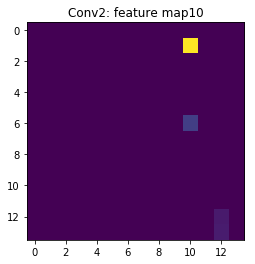

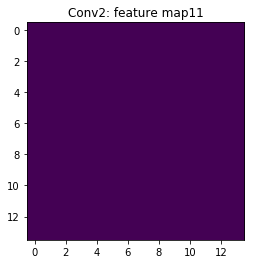

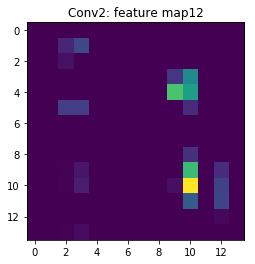

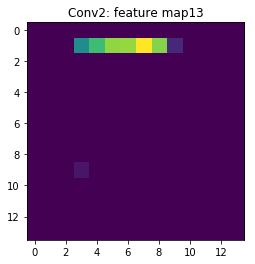

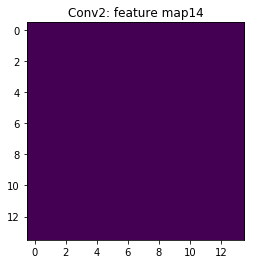

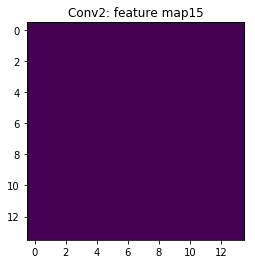

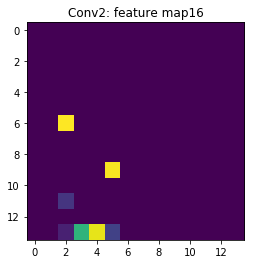

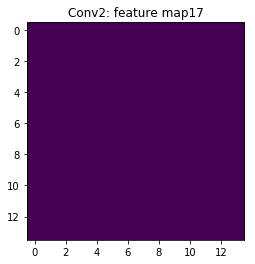

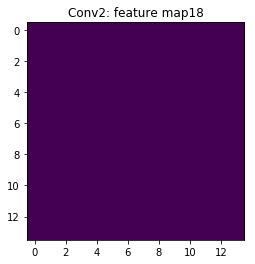

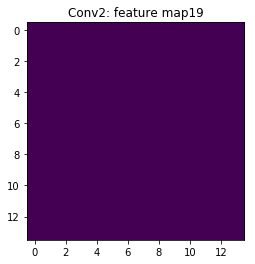

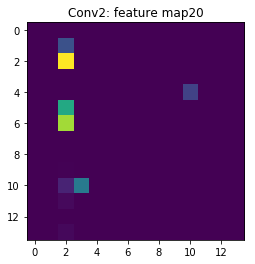

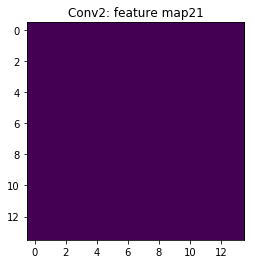

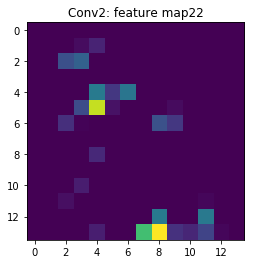

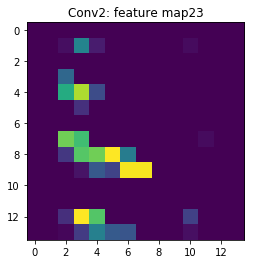

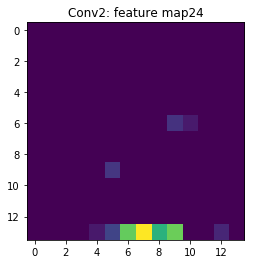

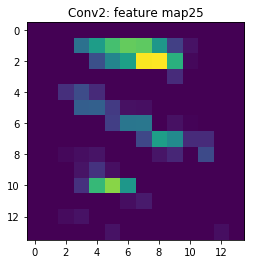

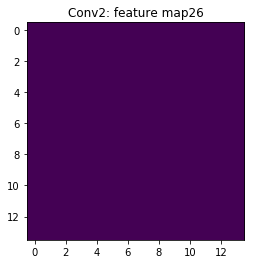

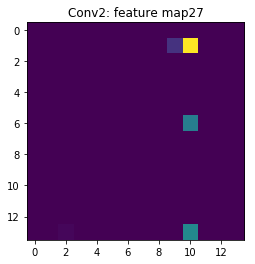

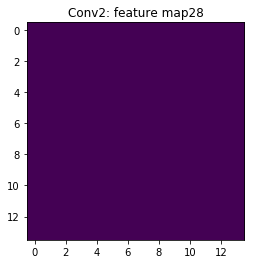

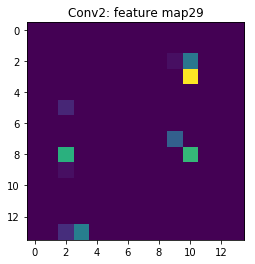

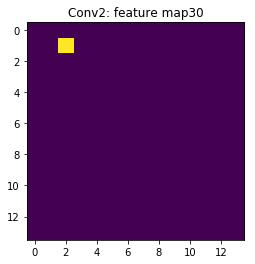

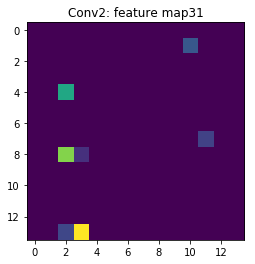

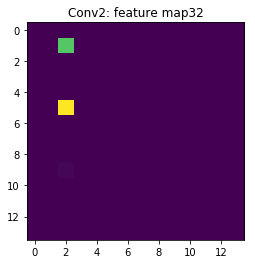

In [273]:
image, label = next(iter(test_loader))  
image = image[0]
image = image.view(-1,1,28,28)
image = image.cuda()
a = F.relu(model.conv2(model.maxpool1(F.relu(model.conv1(image.cpu()))))).cpu().data.numpy()
print(a.shape)
for i in range(1,33):
    plt.imshow(a[0,i-1,:,:])
    plt.title('Conv2: feature map'+str(i))
    plt.show()

**Feature Maps of conv2 together**

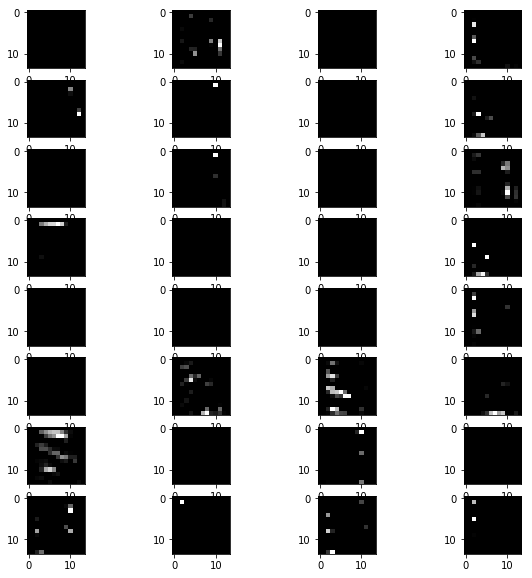

In [274]:

w=20
h=20
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 8
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(a[0,i-1,:,:],'gray')
plt.show()
                        

**Occluding parts of the image**

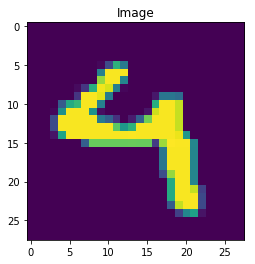

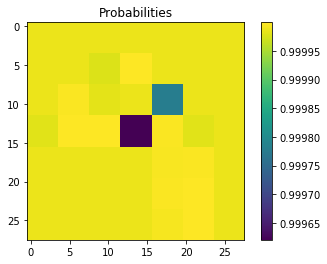

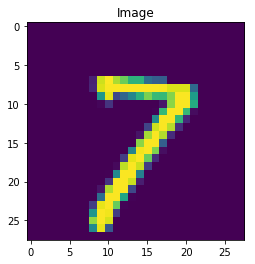

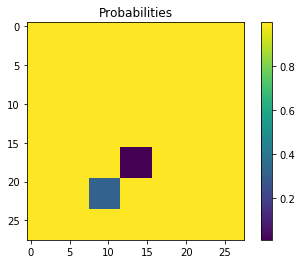

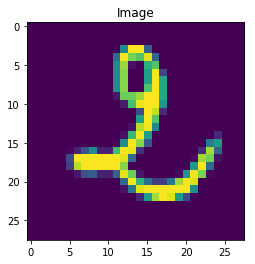

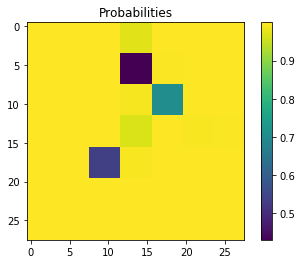

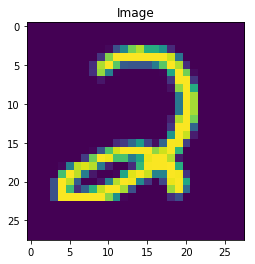

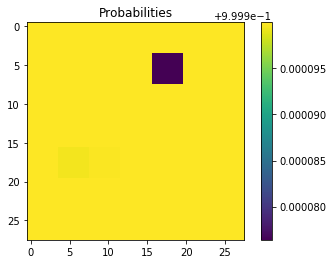

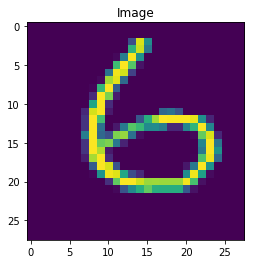

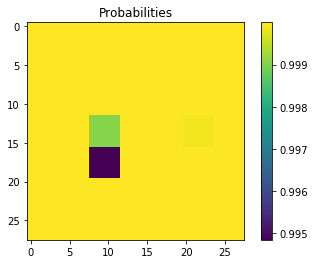

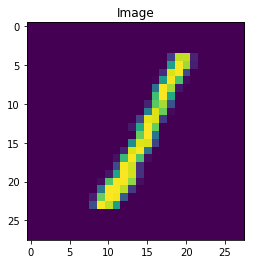

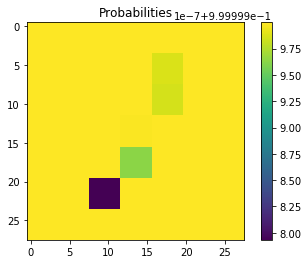

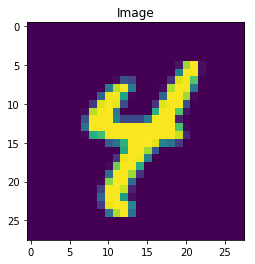

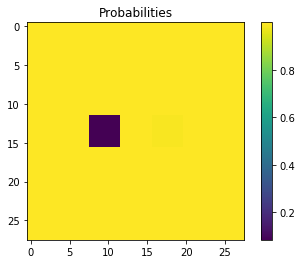

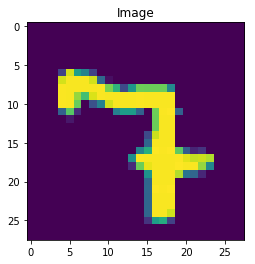

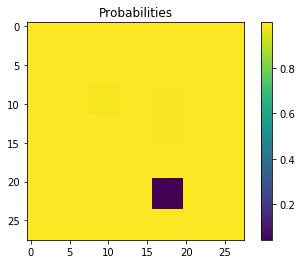

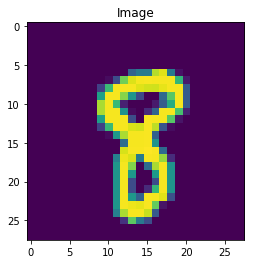

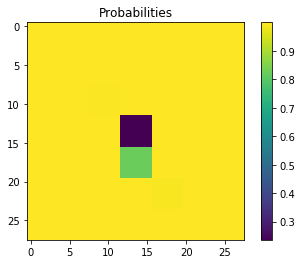

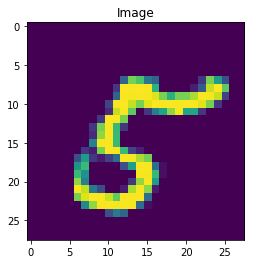

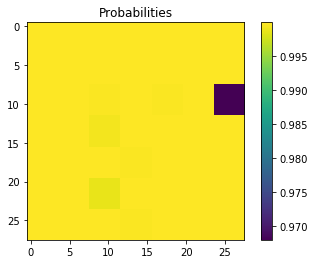

In [275]:

image1, label = next(iter(train_loader)) 
for i in range(10):
    rand = np.random.randint(image1.shape[0])
    image = image1[rand]
    win_size = (4,4)
    occluded_images = []
    for i in range(0,25,4):
      for j in range(0,25,4):
        img = np.copy(image)
        img[i:i+4,j:j+4] = np.zeros((4,4))
        occluded_images.append(img)
    intensity = np.zeros((28,28))
    k = 0
    for i in range(0,25,4):
      for j in range(0,25,4):
        intensity[i:i+4,j:j+4] = F.softmax(model(torch.DoubleTensor(occluded_images[k]).view(-1,1,28,28)),dim = 1)[0,label[rand].item()].item()*np.ones((4,4))
        k = k+1




    plt.imshow(image)
    plt.title('Image')
    plt.show()
    plt.imshow(intensity)
    cbar = plt.colorbar()
    cbar.solids.set_edgecolor("face")
    plt.title('Probabilities')
    plt.show()

# 3. Adversarial Examples

**Load saved model**

Instructions: Change the path to the model saved before

In [276]:
path = '/content/model' 
model1 = Model()
model1.load_state_dict(torch.load(path))
model1 = model1.cpu()
model1.eval()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

**Non-Targeted Attack**

**Generating an image to target class 6**

In [277]:
costs = []
targeted_class = 6
X = np.random.normal(128, 1, (28,28))
X = torch.Tensor(X)
X = X.view(-1,1,28,28)
for i in range(1000):
  output = model1(X)
  cost = 1*output[0,targeted_class]
  costs.append(cost)
  print('cost:',cost.item())
  X.requires_grad = True
  cost.backward()
  if i!=0:
    with torch.no_grad():
        X += 100 * X.grad
    X.grad.zero_()
 
 

       
    


cost: -1.094062328338623
cost: -1.094062328338623
cost: -1.0877721309661865
cost: -1.080536127090454
cost: -1.0761469602584839
cost: -1.0690885782241821
cost: -1.064976453781128
cost: -1.0589418411254883
cost: -1.0541186332702637
cost: -1.0495598316192627
cost: -1.044562816619873
cost: -1.0401134490966797
cost: -1.0347771644592285
cost: -1.0302554368972778
cost: -1.0269004106521606
cost: -1.0216047763824463
cost: -1.0173680782318115
cost: -1.0125857591629028
cost: -1.0086917877197266
cost: -1.0046546459197998
cost: -0.9996253252029419
cost: -0.9960195422172546
cost: -0.9913382530212402
cost: -0.987623929977417
cost: -0.9833787083625793
cost: -0.9800903797149658
cost: -0.975079357624054
cost: -0.9718022346496582
cost: -0.9672749042510986
cost: -0.963939905166626
cost: -0.9593687653541565
cost: -0.9556169509887695
cost: -0.951572060585022
cost: -0.9474824666976929
cost: -0.9443682432174683
cost: -0.9398276209831238
cost: -0.9360913038253784
cost: -0.9319316148757935
cost: -0.928209066390

**Plotting the cost function**

Text(0, 0.5, 'cost')

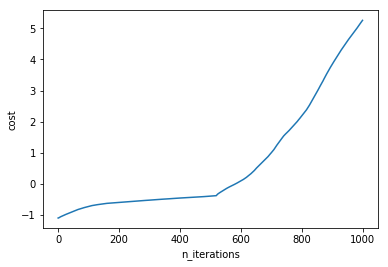

In [278]:
iters = [i for i in range(len(costs))]
plt.plot(iters,costs)
plt.xlabel('n_iterations')
plt.ylabel('cost')

targeted class: 6
predicted class: 6


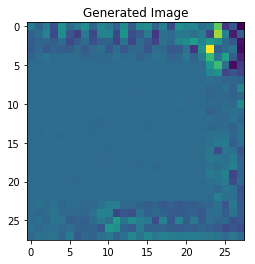

In [279]:
plt.imshow(X.data[0,0,:,:])
plt.title('Generated Image')
print('targeted class:',targeted_class)
print('predicted class:',torch.argmax(model1(X)).item())

**Generating Images for different target classes**

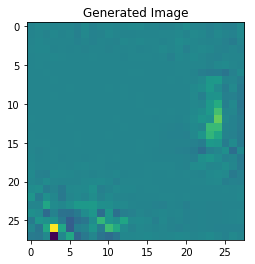

targeted class: 0
predicted class: 0


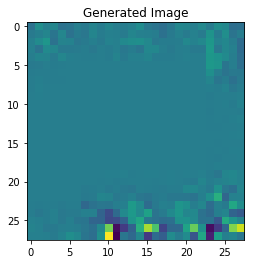

targeted class: 1
predicted class: 1


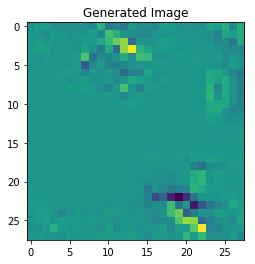

targeted class: 2
predicted class: 2


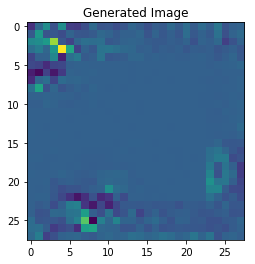

targeted class: 3
predicted class: 3


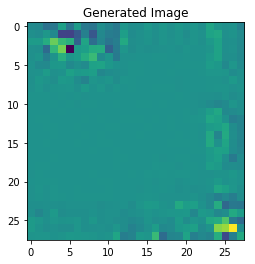

targeted class: 4
predicted class: 4


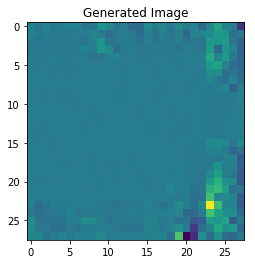

targeted class: 5
predicted class: 5


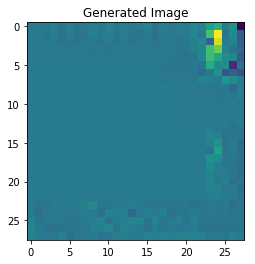

targeted class: 6
predicted class: 6


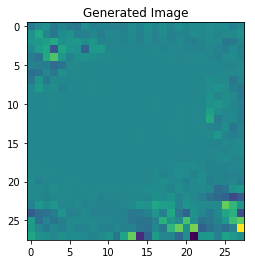

targeted class: 7
predicted class: 7


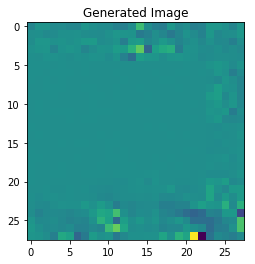

targeted class: 8
predicted class: 8


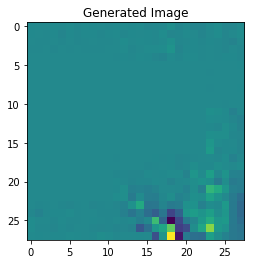

targeted class: 9
predicted class: 9


In [280]:
for i in range(10):
  model1 = Model()
  model1.load_state_dict(torch.load('/content/model'))
  model1 = model1.cpu()
  model1.eval()
  targeted_class = i
  X = np.random.normal(128, 1, (28,28))
  X = torch.Tensor(X)
  X = X.view(-1,1,28,28)
  for i in range(1500):
    output = model1(X)
    cost = 1*output[0,targeted_class]
    X.requires_grad = True
    cost.backward()
    if i!=0:
      with torch.no_grad():
          X += 100 * X.grad
      X.grad.zero_()
  plt.imshow(X.data[0,0,:,:])
  plt.title('Generated Image')
  plt.show()
  print('targeted class:',targeted_class)
  print('predicted class:',torch.argmax(model1(X)).item())


       
    


**Targeted Attack**

**Generating image targeted to image of digit zero and target it to class 6**

In [285]:
X = np.random.normal(128, 1, (28,28))
X = torch.Tensor(X)
X = X.view(-1,1,28,28)
targeted_class = 6

for i in range(1200):
  output = model1(X)
  cost = 1*output[0,targeted_class] - 0.01*torch.mean((X - torch.Tensor(train_images[1]).view(-1,1,28,28))**2)
  print(cost.item())
  X.requires_grad = True
  cost.backward()
  if i!=0:
    with torch.no_grad():
        X += 50 * X.grad
    X.grad.zero_()
 
 
predicted_label = torch.argmax(model1(X))
       
    


-149.4519500732422
-149.4519500732422
-149.06602478027344
-148.68112182617188
-148.29769897460938
-147.91537475585938
-147.53414916992188
-147.15426635742188
-146.77597045898438
-146.39810180664062
-146.02220153808594
-145.64649963378906
-145.27279663085938
-144.89930725097656
-144.5269012451172
-144.1565399169922
-143.78611755371094
-143.4170379638672
-143.04922485351562
-142.6820526123047
-142.31591796875
-141.9510040283203
-141.58656311035156
-141.2237091064453
-140.8612060546875
-140.49996948242188
-140.13958740234375
-139.7797393798828
-139.42144775390625
-139.06399536132812
-138.70692443847656
-138.3511962890625
-137.99620056152344
-137.64222717285156
-137.2894287109375
-136.9365234375
-136.58572387695312
-136.23501586914062
-135.88571166992188
-135.53749084472656
-135.18922424316406
-134.84315490722656
-134.49708557128906
-134.1519012451172
-133.80828857421875
-133.46458435058594
-133.1230010986328
-132.78115844726562
-132.4407958984375
-132.1012420654297
-131.76193237304688
-13

targeted class: 6
predicted class: 6


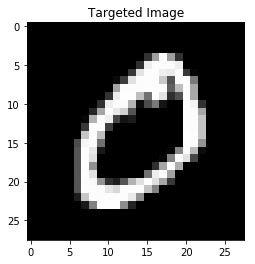

Text(0.5, 1.0, 'Generated Image')

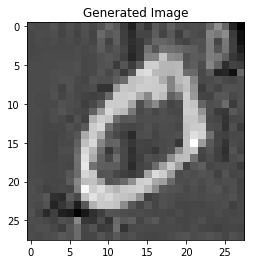

In [286]:
print('targeted class:',targeted_class)
print('predicted class:',torch.argmax(model1(X)).item())

plt.imshow(train_images[1],'gray')
plt.title('Targeted Image')
plt.show()
plt.imshow(X.data[0,0,:,:],'gray')
plt.title('Generated Image')

**Generating Image for different targeted Images and classes**

targeted class: 0
predicted class: 0


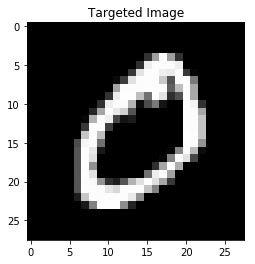

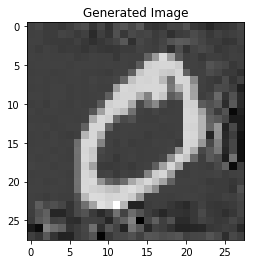

targeted class: 0
predicted class: 0


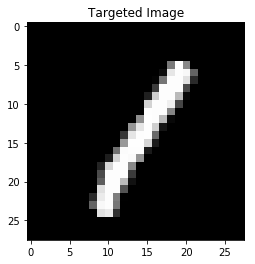

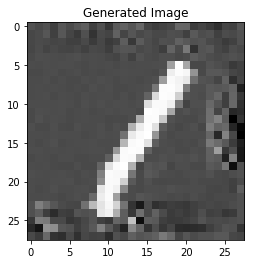

targeted class: 0
predicted class: 0


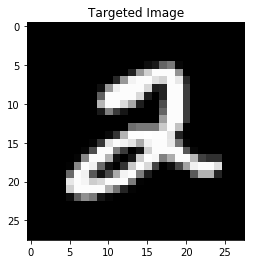

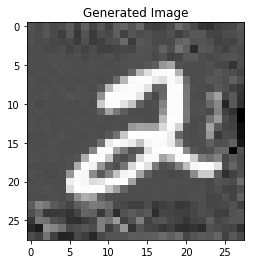

targeted class: 0
predicted class: 0


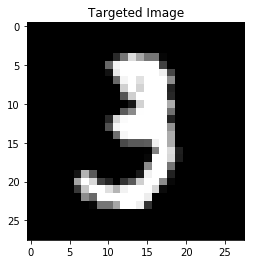

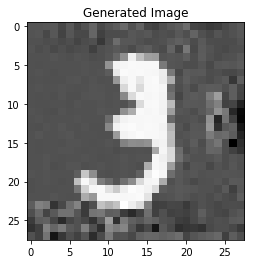

targeted class: 0
predicted class: 0


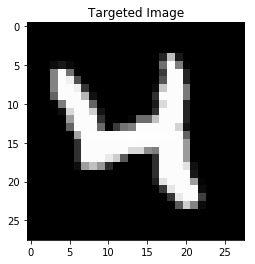

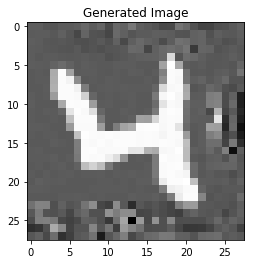

targeted class: 0
predicted class: 0


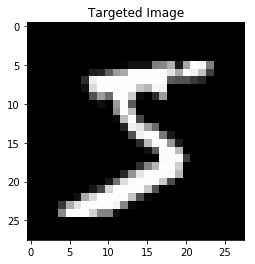

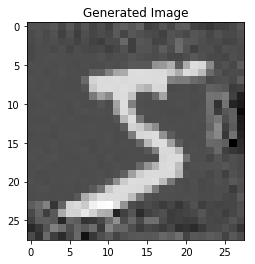

targeted class: 0
predicted class: 0


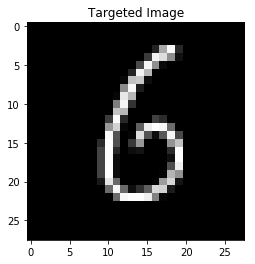

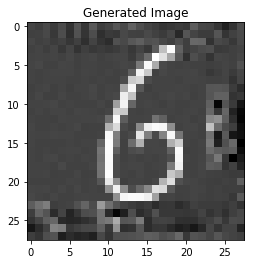

targeted class: 0
predicted class: 0


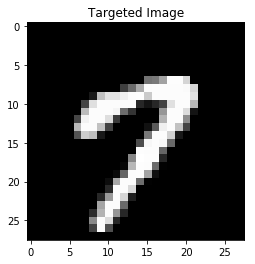

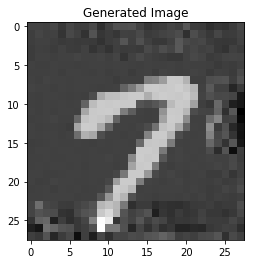

targeted class: 0
predicted class: 0


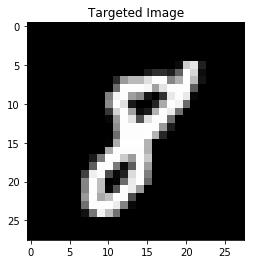

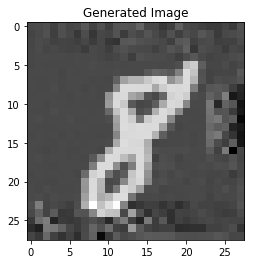

targeted class: 0
predicted class: 0


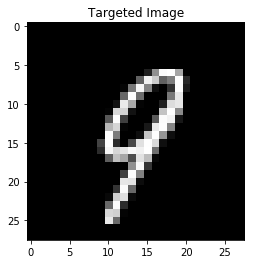

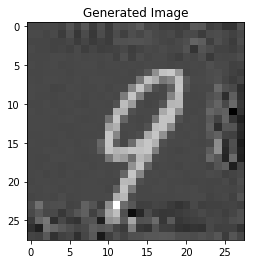

targeted class: 1
predicted class: 1


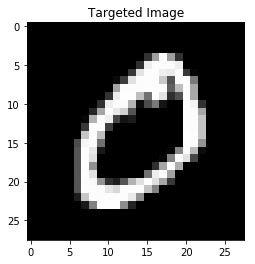

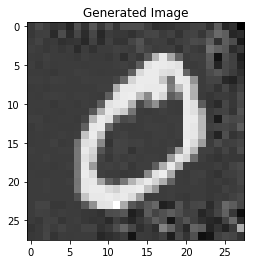

targeted class: 1
predicted class: 1


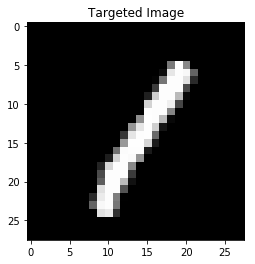

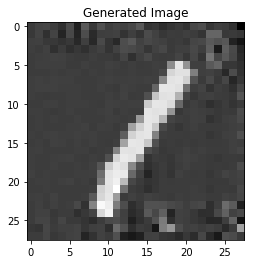

targeted class: 1
predicted class: 1


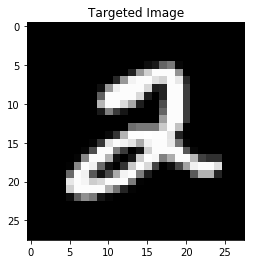

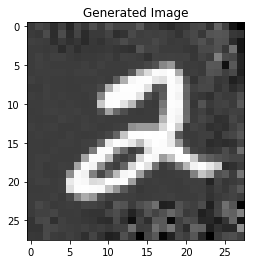

targeted class: 1
predicted class: 1


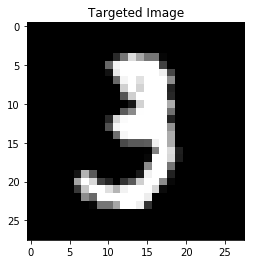

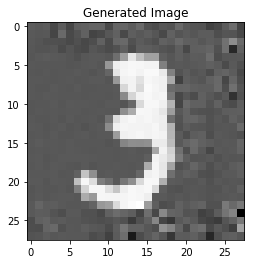

targeted class: 1
predicted class: 1


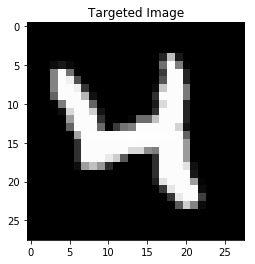

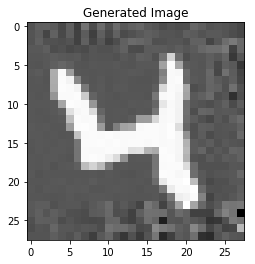

targeted class: 1
predicted class: 1


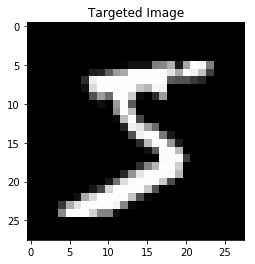

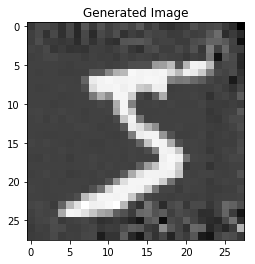

targeted class: 1
predicted class: 1


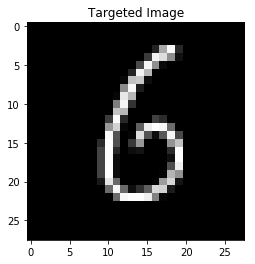

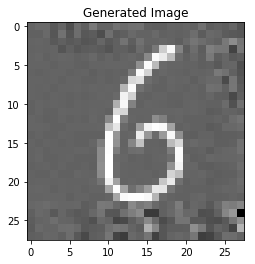

targeted class: 1
predicted class: 1


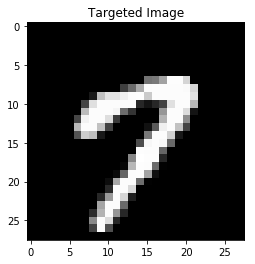

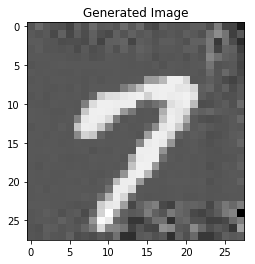

targeted class: 1
predicted class: 1


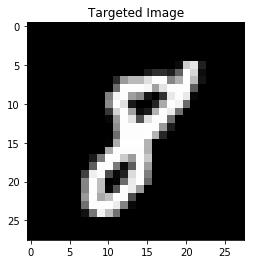

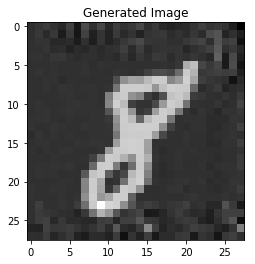

targeted class: 1
predicted class: 1


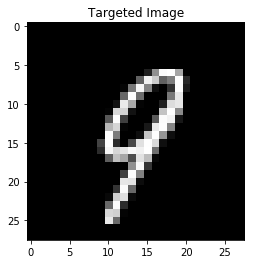

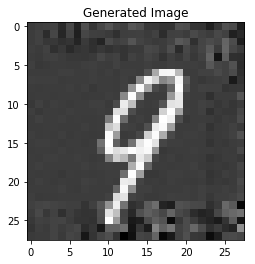

targeted class: 2
predicted class: 2


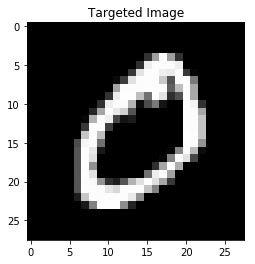

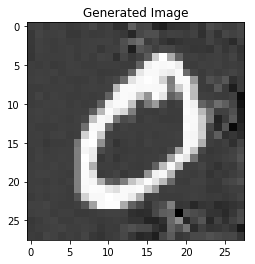

targeted class: 2
predicted class: 2


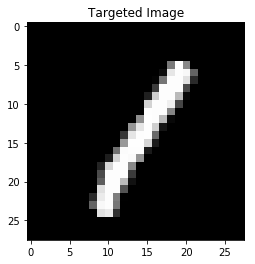

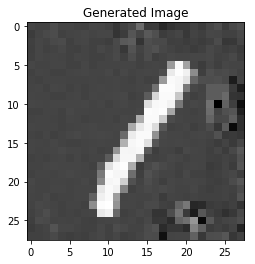

targeted class: 2
predicted class: 2


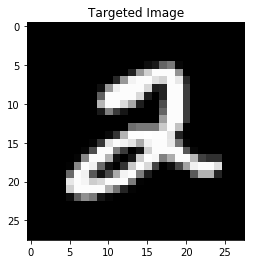

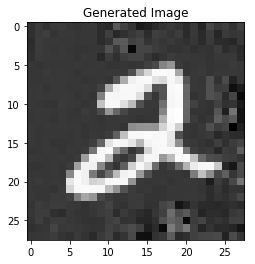

targeted class: 2
predicted class: 2


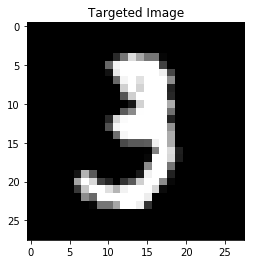

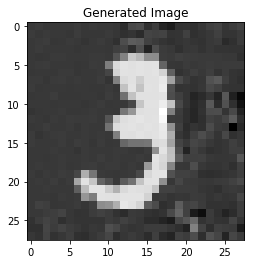

targeted class: 2
predicted class: 2


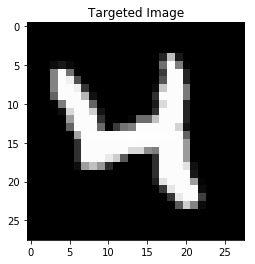

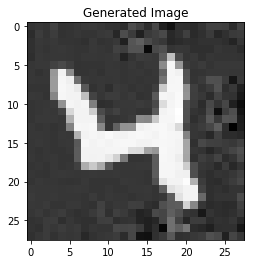

targeted class: 2
predicted class: 2


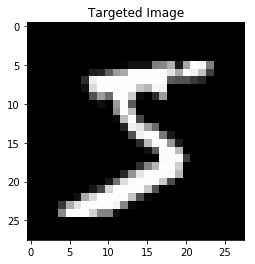

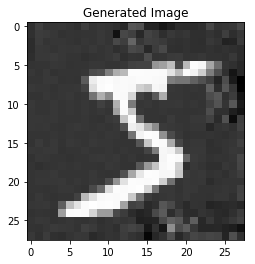

targeted class: 2
predicted class: 2


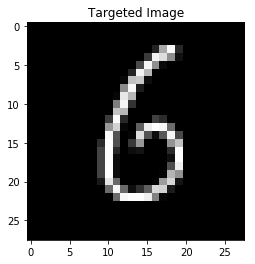

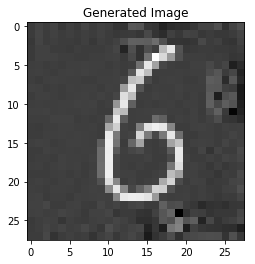

targeted class: 2
predicted class: 2


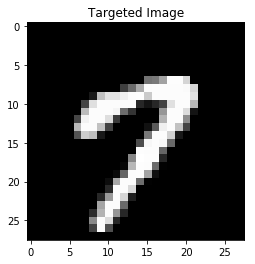

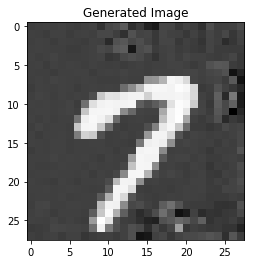

targeted class: 2
predicted class: 2


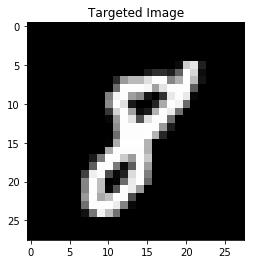

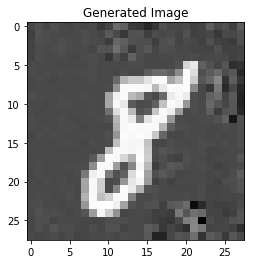

targeted class: 2
predicted class: 2


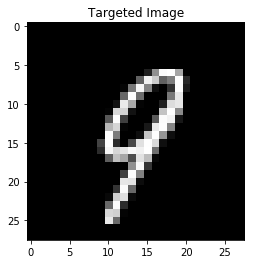

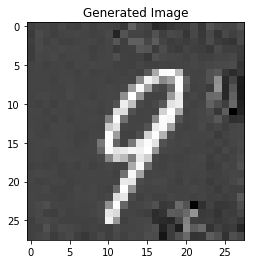

targeted class: 3
predicted class: 0


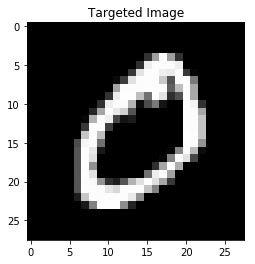

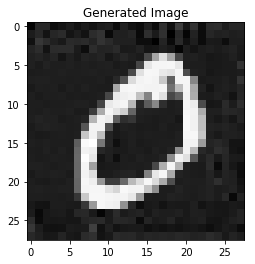

targeted class: 3
predicted class: 1


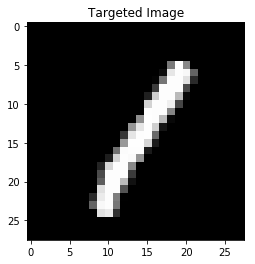

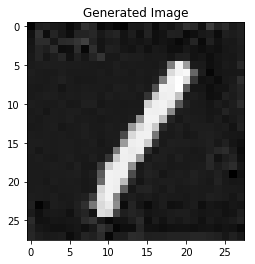

targeted class: 3
predicted class: 8


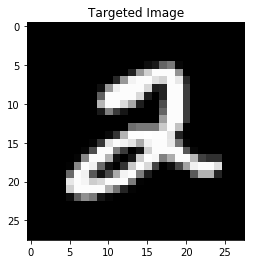

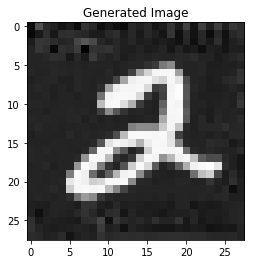

targeted class: 3
predicted class: 0


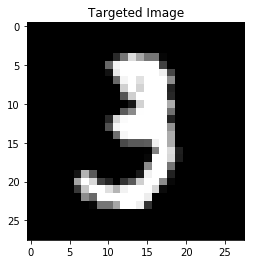

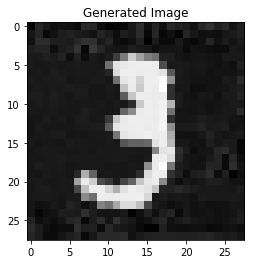

targeted class: 3
predicted class: 4


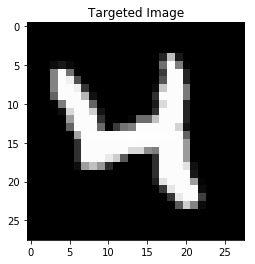

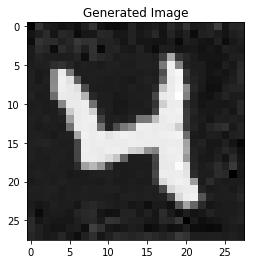

targeted class: 3
predicted class: 0


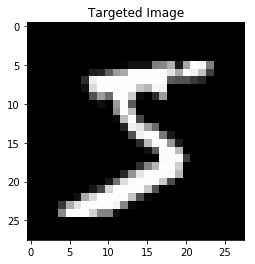

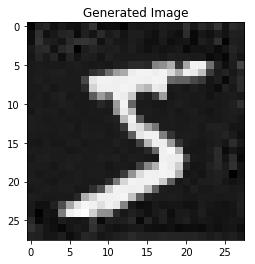

targeted class: 3
predicted class: 8


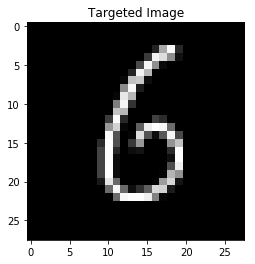

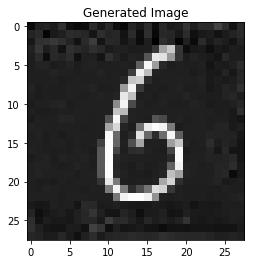

targeted class: 3
predicted class: 0


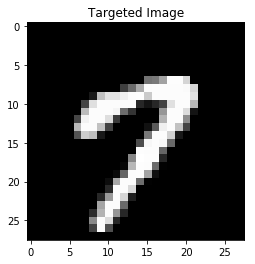

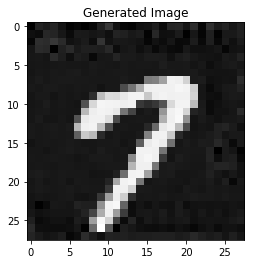

targeted class: 3
predicted class: 0


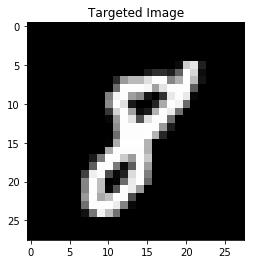

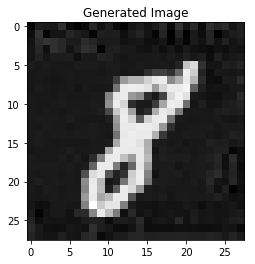

targeted class: 3
predicted class: 0


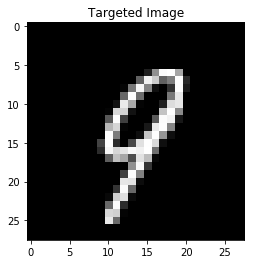

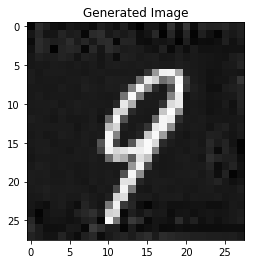

targeted class: 4
predicted class: 4


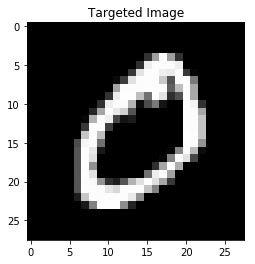

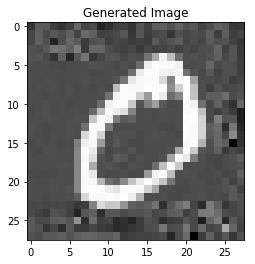

targeted class: 4
predicted class: 4


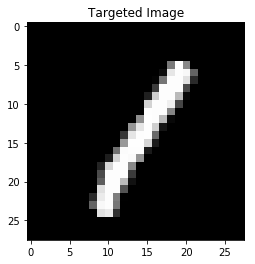

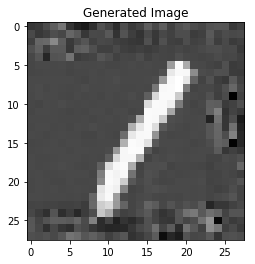

targeted class: 4
predicted class: 4


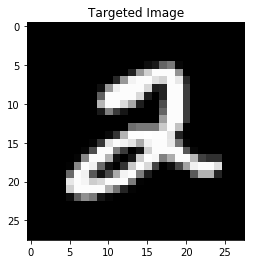

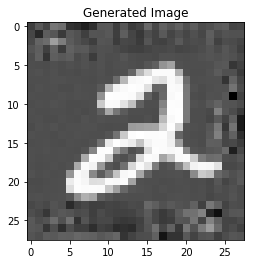

targeted class: 4
predicted class: 4


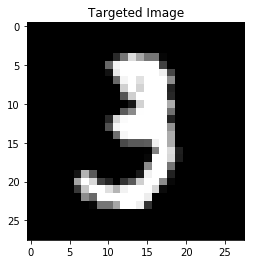

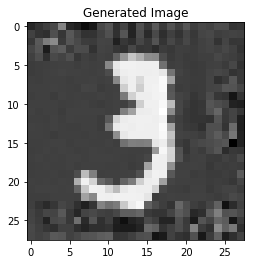

targeted class: 4
predicted class: 4


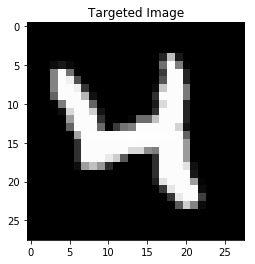

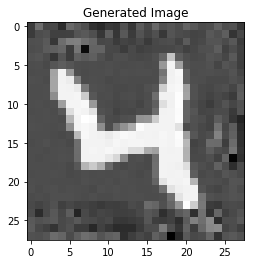

targeted class: 4
predicted class: 4


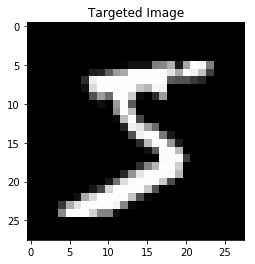

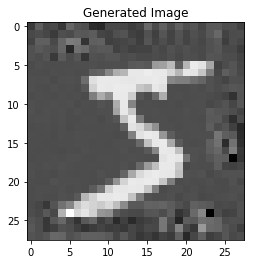

targeted class: 4
predicted class: 4


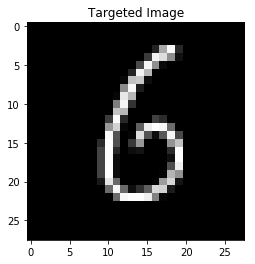

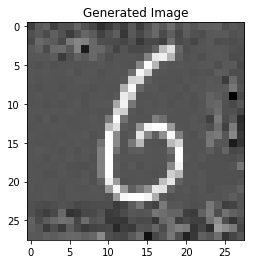

targeted class: 4
predicted class: 4


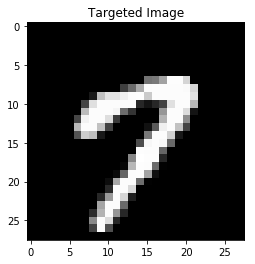

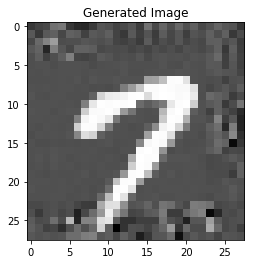

targeted class: 4
predicted class: 4


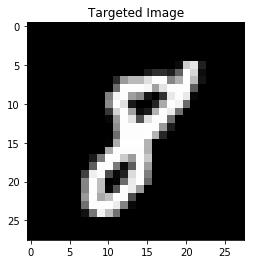

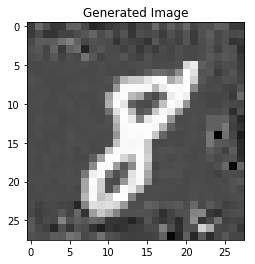

targeted class: 4
predicted class: 4


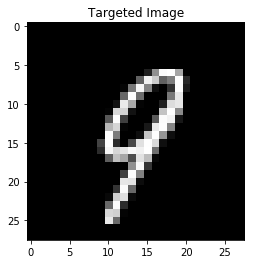

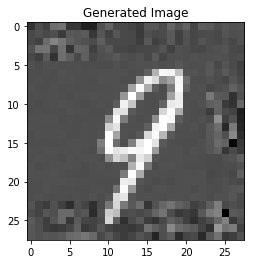

targeted class: 5
predicted class: 5


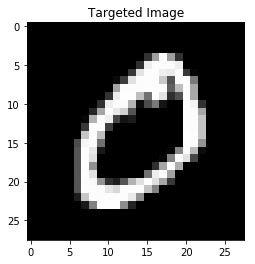

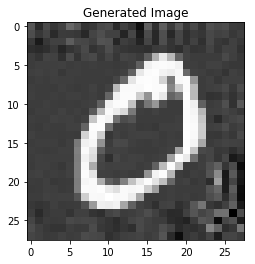

targeted class: 5
predicted class: 5


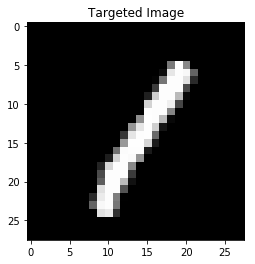

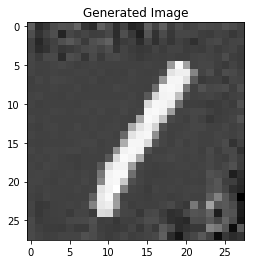

targeted class: 5
predicted class: 5


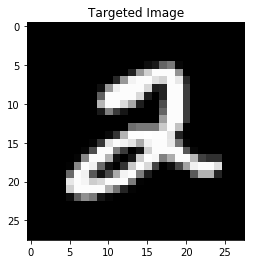

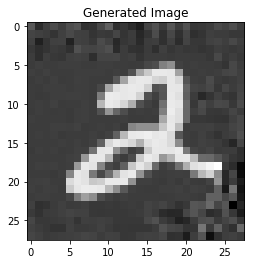

targeted class: 5
predicted class: 5


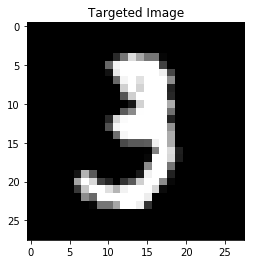

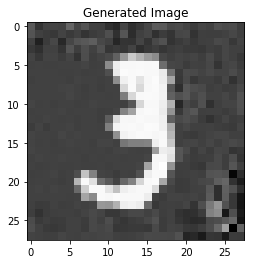

targeted class: 5
predicted class: 5


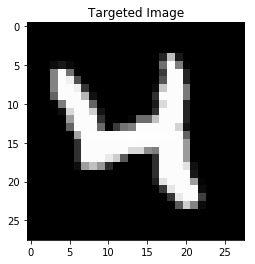

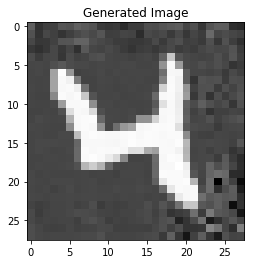

targeted class: 5
predicted class: 5


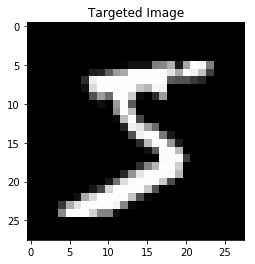

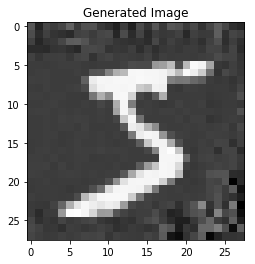

targeted class: 5
predicted class: 5


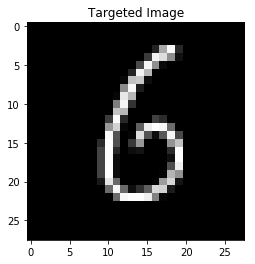

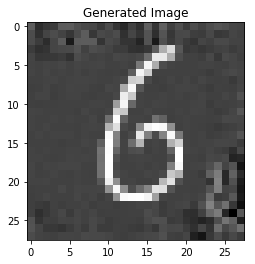

targeted class: 5
predicted class: 5


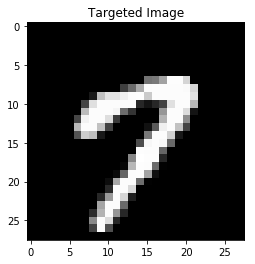

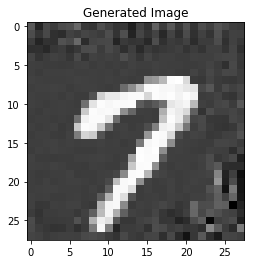

targeted class: 5
predicted class: 5


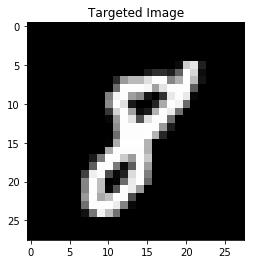

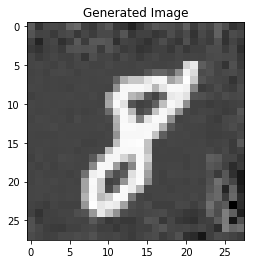

targeted class: 5
predicted class: 5


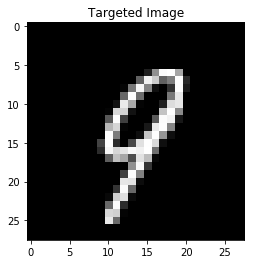

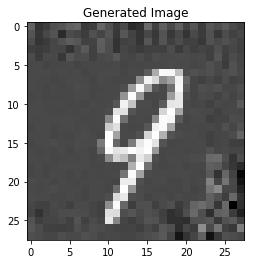

targeted class: 6
predicted class: 0


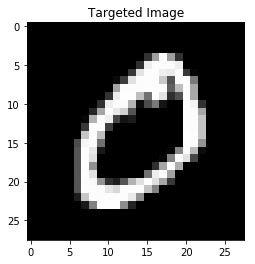

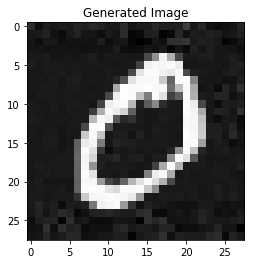

targeted class: 6
predicted class: 1


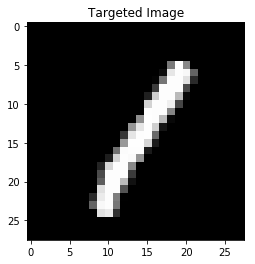

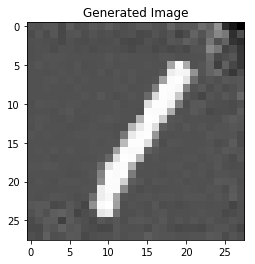

targeted class: 6
predicted class: 1


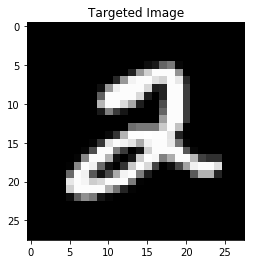

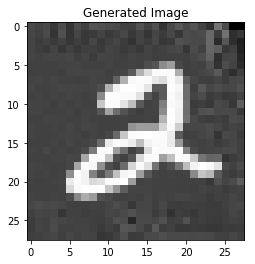

targeted class: 6
predicted class: 1


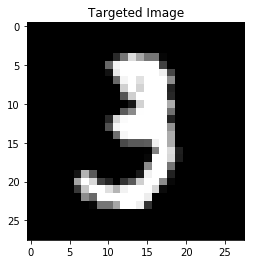

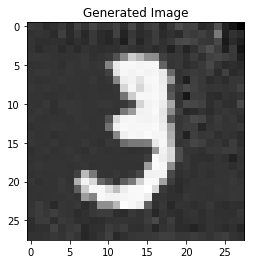

targeted class: 6
predicted class: 1


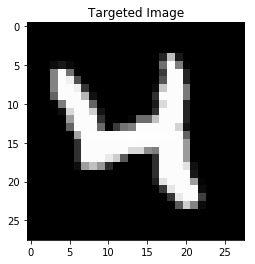

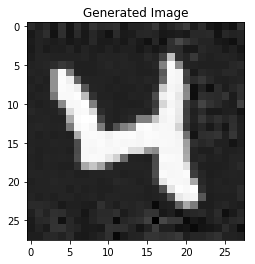

targeted class: 6
predicted class: 1


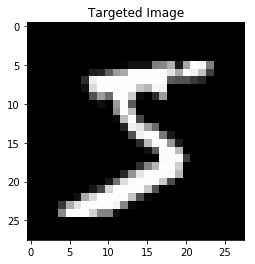

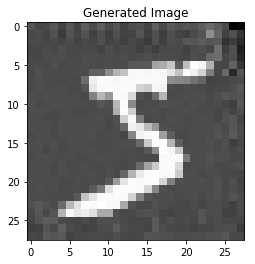

targeted class: 6
predicted class: 1


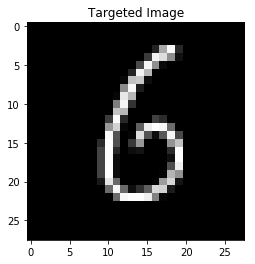

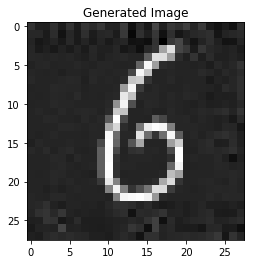

targeted class: 6
predicted class: 1


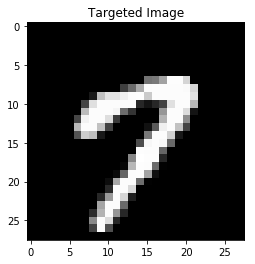

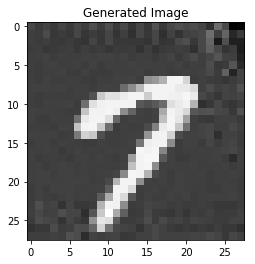

targeted class: 6
predicted class: 1


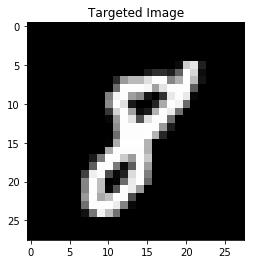

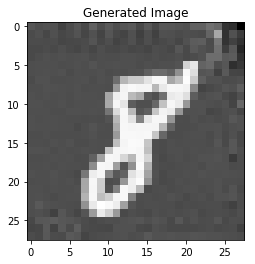

targeted class: 6
predicted class: 1


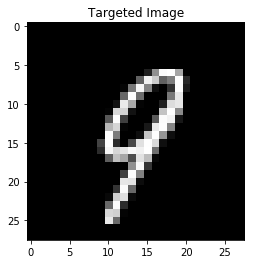

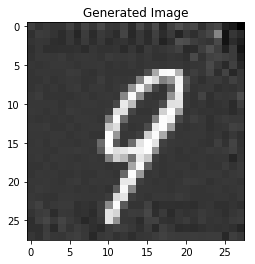

targeted class: 7
predicted class: 7


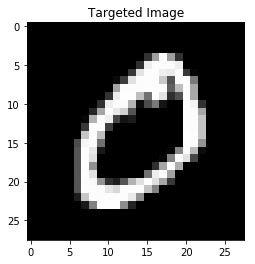

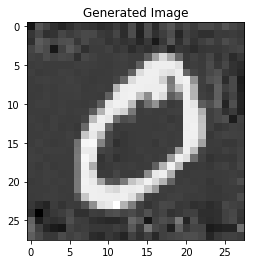

targeted class: 7
predicted class: 1


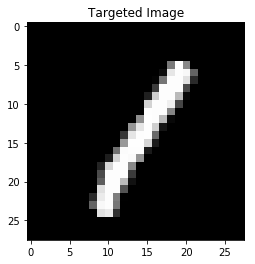

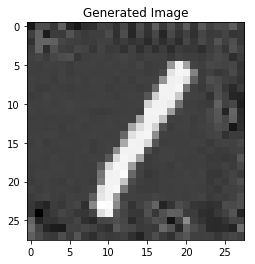

targeted class: 7
predicted class: 1


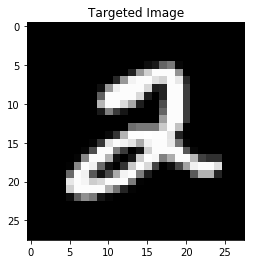

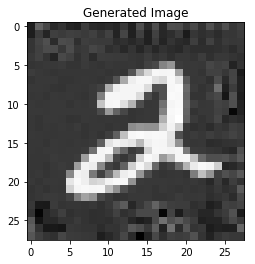

KeyboardInterrupt: ignored

In [287]:

targeted_images = [1,23,5,10,20,0,18,15,17,22]
targeted_classes = [0,1,2,3,4,5,6,7,8,9]
for target_class in targeted_classes: 
  for target_image in targeted_images:
   

    X = np.random.normal(128, 1, (28,28))
    X = torch.Tensor(X)
    X = X.view(-1,1,28,28)
   

    for i in range(1500):
      output = model1(X)
      cost = 1*output[0,target_class] - 0.01*torch.mean((X - torch.Tensor(train_images[target_image]).view(-1,1,28,28))**2)
      X.requires_grad = True
      cost.backward()
      if i!=0:
        with torch.no_grad():
            X += 50 * X.grad
        X.grad.zero_()
 
 

       
    

    print('targeted class:',target_class)
    print('predicted class:',torch.argmax(model1(X)).item())

    plt.imshow(train_images[target_image],'gray')
    plt.title('Targeted Image')
    plt.show()
    plt.imshow(X.data[0,0,:,:],'gray')
    plt.title('Generated Image')
    plt.show()
    

**Adding Noise**

Adding noise to image to target the class as Zero

In [288]:

N = torch.zeros((28,28))
X_img = torch.Tensor(train_images[6])
for i in range(1500):
    X = X_img + N
    X = X.view(-1,1,28,28)
    output = model1(X)
    cost = 1*output[0,0]
    print('Cost:',cost.item())
    N.requires_grad = True
    cost.backward()
    if i!=0:
      with torch.no_grad():
          N += 10 * N.grad
      N.grad.zero_()

Cost: -2.5541040897369385
Cost: -2.5541040897369385
Cost: -2.5189034938812256
Cost: -2.470182180404663
Cost: -2.4182162284851074
Cost: -2.362955093383789
Cost: -2.315582513809204
Cost: -2.2629637718200684
Cost: -2.206791400909424
Cost: -2.1492412090301514
Cost: -2.0918667316436768
Cost: -2.0364301204681396
Cost: -1.979731798171997
Cost: -1.9216930866241455
Cost: -1.8630626201629639
Cost: -1.8031070232391357
Cost: -1.743265151977539
Cost: -1.6838667392730713
Cost: -1.6213428974151611
Cost: -1.5561792850494385
Cost: -1.4927294254302979
Cost: -1.4301514625549316
Cost: -1.3667938709259033
Cost: -1.3027184009552002
Cost: -1.235095500946045
Cost: -1.1736328601837158
Cost: -1.113459825515747
Cost: -1.053372859954834
Cost: -0.9964281916618347
Cost: -0.9393441081047058
Cost: -0.881565511226654
Cost: -0.8244890570640564
Cost: -0.7664598822593689
Cost: -0.7088953852653503
Cost: -0.6512452960014343
Cost: -0.5940355658531189
Cost: -0.5368642210960388
Cost: -0.4800734221935272
Cost: -0.4243590533733

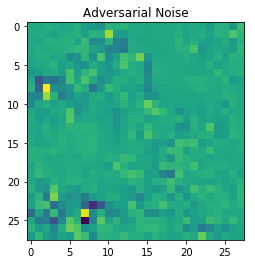

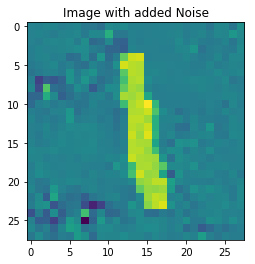

targeted class: 0
predicted class: 0


In [289]:
plt.imshow(N.data)
plt.title('Adversarial Noise')
plt.show()
plt.imshow(X.data[0,0,:,:])
plt.title('Image with added Noise')
plt.show()
print('targeted class:',0)
print('predicted class:',torch.argmax(model1(X)).item())

**Generating Adversarial Noises targeted at different classes**

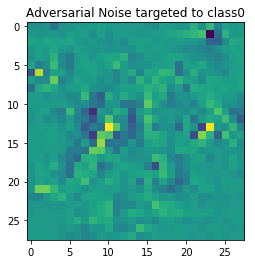

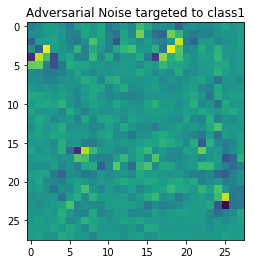

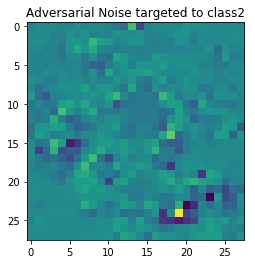

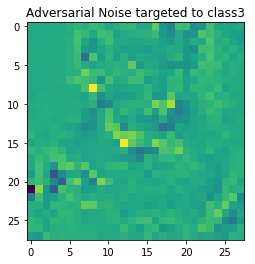

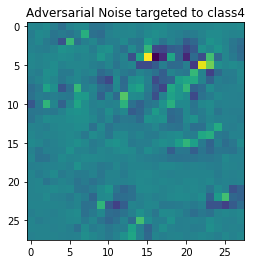

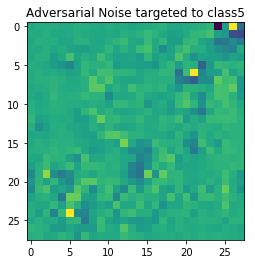

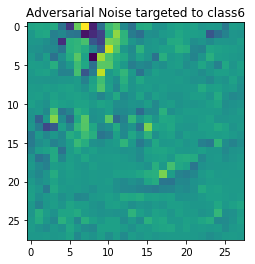

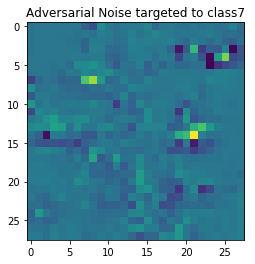

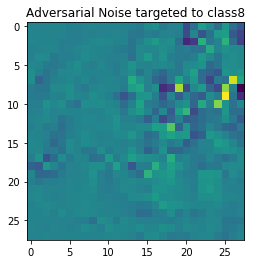

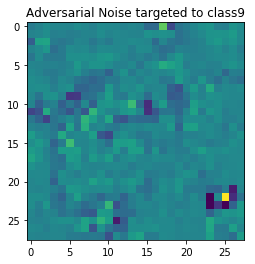

In [229]:
Adversarial_noises = []

for target_label in range(10):
   
    N = torch.zeros((28,28))
    X_img = torch.Tensor(train_images[np.random.randint(60000-1)])
    for i in range(1500):
        X = X_img + N
        X = X.view(-1,1,28,28)
        output = model1(X)
        cost = 1*output[0,target_label]
        N.requires_grad = True
        cost.backward()
        if i!=0:
          with torch.no_grad():
              N += 8 * N.grad
          N.grad.zero_()
    plt.imshow(N.data)
    plt.title('Adversarial Noise targeted to class'+str(target_label))
    plt.show()
    Adversarial_noises.append(N)

**Prediction on Test images + Adversarial Noise targeted to different classes**

Targeted Noise Class: 0
True Label: 9
Predicted Label 0


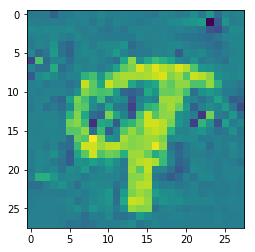

Targeted Noise Class: 1
True Label: 0
Predicted Label 1


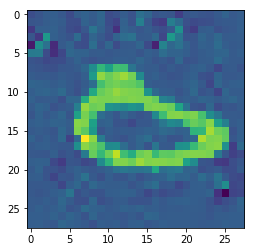

Targeted Noise Class: 2
True Label: 6
Predicted Label 2


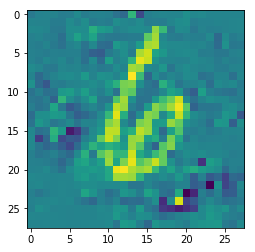

Targeted Noise Class: 3
True Label: 7
Predicted Label 3


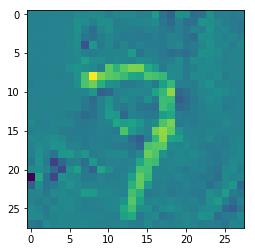

Targeted Noise Class: 4
True Label: 5
Predicted Label 4


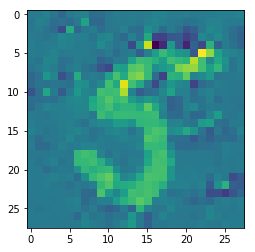

Targeted Noise Class: 5
True Label: 6
Predicted Label 5


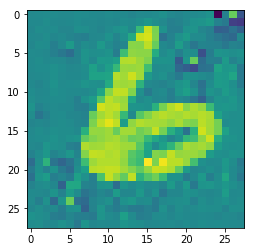

Targeted Noise Class: 6
True Label: 2
Predicted Label 6


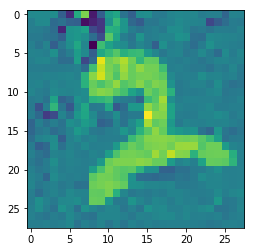

Targeted Noise Class: 7
True Label: 4
Predicted Label 7


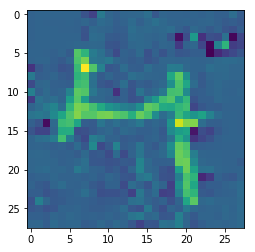

Targeted Noise Class: 8
True Label: 3
Predicted Label 8


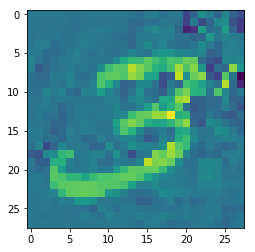

Targeted Noise Class: 9
True Label: 2
Predicted Label 9


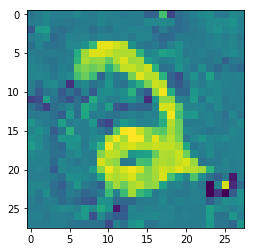

In [230]:
for i in range(10):
  rand = np.random.randint(10000-1)
  img = torch.Tensor(test_images[rand]) + Adversarial_noises[i]
  label = test_labels[rand]
  img = img.view(-1,1,28,28)
  output = model1(img)
  pred = torch.argmax(output).item()
  print('Targeted Noise Class:',i)
  print('True Label:',label)
  print('Predicted Label',pred)
  plt.imshow(img.data[0,0,:,:])
  plt.show()
  

4